In [943]:
import numpy as np
from scipy import stats, special, optimize
import seaborn as sb
import matplotlib.pyplot as plt
import statsmodels.api as sm
from math import factorial, ceil
from random import getrandbits
from time import time, perf_counter
from numba import jit

In [944]:
np.random.seed(12345) 

# Raport I - metody generowania zmiennych losowych
### Autorzy: Aleksandra Hodera (268733), Aleksandra Polak (268786)

## Spis treści:
1. Wstęp  
2.  Metody generowania zmiennych losowych: 
      - Metoda odwracania dystrybuanty:
        - rozkłady dyskretne:
          - rozkład geometryczny,
          - rozkład Poissona,
        - rozkłady ciągłe: 
          - rozkład Pareto, 
          - rozkład Weibulla.  
      - Metoda akceptacji-odrzucenia: 
        - rozkłady dyskretne:
          - rozkład o zadanych skokach,
          - rozkład Poissona, 
        - rozkład ciągły - rozkład Weibulla.
      - Metody generowania rozkładu normalnego: 
        - metoda Boxa-Mullera,
        - metoda biegunowa, 
        - metoda akceptacji-odrzucenia,
        - porównanie czasów działania powyższych metod.
      - Algorytm Ziggurata dla rozkładu Pareto.
3. Zakończenie 
4. Źródła 

## 1. Wstęp: 

W raporcie zajmiemy się generacją zmiennych losowych z wykorzystaniem algorytmów poznanych na wykładzie oraz laboratoriach. Omówimy metody odwracania dystrybuanty, akceptacji - odrzucenia, zarówno dla rozkładów dyskretnych, jak i ciągłych. Zajmiemy się także generowaniem rozkładu normalnego na trzy różne sposoby oraz algorytmem Ziggurata.
Dodatkowo sprawdzimy poprawność wszystkich powyższych generatorów porównując między innymi: gęstości teoretyczne (teoretyczne rozkłady prawdopodobieństwa) z histogramami (rozkładami prawdopodobieństwa), dystrybuanty teoretyczne i empiryczne, wartości oczekiwane, wariancje oraz inne charakterystyki rozkładów.

## 2. Metody generowania zmiennych losowych:

Zanim przejdziemy do generowania zmiennych losowych stworzymy funkcje wizualizujące oraz liczące, dzięki którym będziemy mogli przetestować poprawność naszych generatorów.

In [945]:
def skewness(x):
    n = len(x)
    result = ((1/n)*sum((x - np.mean(x))**3))/(((1/n)*sum((x - np.mean(x))**2))**(3/2))
    return result


def kurtosis(x): 
    n = len(x)
    result = (((1/n)*sum((x - np.mean(x))**4))/((1/n)*sum((x - np.mean(x))**2))**2) - 3
    return result


def pmf(x, size):
    p_values = []
    for i in set(x):
        p_values.append(np.count_nonzero(x == i))
    p_values = np.array(p_values)/size
        
    return p_values


def cdf(x, size):
    F_values = []
    for i in set(x):
        F_values.append(np.count_nonzero(x <= i))
    F_values = np.array(F_values)/size
    
    F_values = np.insert(F_values, [0, 0], 0) 

    return F_values

In [946]:
def visualize_pmf(X, N, p_th, x, name):
    p_em = pmf(X, N)
    
    plt.scatter(x, p_em, label = "Empiryczny")
    plt.vlines(x, 0, p_em, lw = 5, alpha = 0.5)
    
    plt.scatter(x, p_th, c = "red", label = "Teoretyczny", alpha = 0.6)
    plt.vlines(x, 0, p_th, colors = "red", lw = 5, alpha = 0.4)

    plt.xlabel("X")
    plt.ylabel("$P(X=i)$")
    plt.title(f"Porównanie rozkładu prawdopodobieństwa {name}")
    plt.legend(loc='best', frameon=False)
    


def visualize_cdf_disrete(X, N, pk, name):
    F_em = cdf(X, N)
    x  = np.arange(len(F_em))

    plt.step(x, F_em, label = "Empiryczna")

    F_theo = [sum(pk[:i]) for i in range(len(pk)+1)]
    F_theo = np.insert(F_theo, 0, 0)
    plt.step(x, F_theo, c = "red", alpha = 0.5, label = "Teoretyczna")

    plt.xlabel("X")
    plt.ylabel("$F(X)$")
    plt.title(f"Porównanie dystrybuant rozkładu {name}")
    plt.legend(loc='best', frameon=False)   



def visualize_pdf(f_em, f_theo, x, name):
    plt.hist(f_em, bins = 30, density=True, label = "histogram generatora")

    plt.plot(x, f_theo, label = "gęstość teoretyczna", color = "red")

    plt.title(f"Porównanie gęstości rozkładu {name}")
    plt.xlabel("$x$")
    plt.ylabel("$f(x)$")
    plt.legend(frameon=False)



def visualize_cdf(F_em, F_theo, x, name):
    sb.ecdfplot(data = F_em, label = "Dystrybuanta empiryczna")
    
    plt.plot(x, F_theo, label = "Dystrybuanta teoretyczna", alpha = 0.5, color = "red")

    plt.title(f"Porównanie dystrubuant rozkładu {name}")
    plt.xlabel("$x$")
    plt.ylabel("$F(x)$")
    plt.legend(frameon=False)



def quantiles(x, theo, name):
    sm.qqplot(x, dist=theo, line = '45')
    plt.xlabel("Kwantyle teoretyczne")
    plt.ylabel("Kwantyle empiryczne")
    plt.title(f"Wykres kwantylowy dla próbki względem rozkładu {name}")


def visualize_pdf_Y(f_em, f_theo, x, name):
    plt.hist(f_em, bins = 30, density=True, label = "histogram generatora")

    plt.plot(x, f_theo, label = "gęstość teoretyczna", color = "red")

    plt.title(f"Porównanie gęstości rozkładu {name}")
    plt.xlabel("$y$")
    plt.ylabel("$f(y)$")
    plt.legend(frameon=False)



def visualize_cdf_Y(F_em, F_theo, x, name):
    sb.ecdfplot(data = F_em, label = "Dystrybuanta empiryczna")
    
    plt.plot(x, F_theo, label = "Dystrybuanta teoretyczna", alpha = 0.5, color = "red")

    plt.title(f"Porównanie dystrubuant rozkładu {name}")
    plt.xlabel("$y$")
    plt.ylabel("$F(y)$")
    plt.legend(frameon=False)


- ### **Metoda odwracania dystrybuanty - rozkłady dyskretne:**
Chcemy wygenerować realizację zmiennej losowej X o rozkładzie dyskretnym: $$ \\ P(X=x_i) = p_i, \ \ \ \ \ i = 1,2,...,n, \ \ \ \ \  p_i \geqslant 0, \ \ \ \ \  \sum_{i=1}^{n} p_i = 1 $$

#### **Algorytm ogólny**:
1. Generuj $ U \sim U(0,1) $.
2. Wyznacz $ j \in {1,2,...,n} $ takie, że: $\\ \sum_{i=1}^{j-1} p_i < U \leqslant \sum_{i=1}^{j} p_i \iff F_X (x_{j-1}) < U \leqslant F_X (x_{j}) $
3. Zwróć $ X = x_j $


#### **PRZYKŁAD 1 - rozkład geometryczny**

Chcemy generować zmienną losową X z rozkładu geometrycznego: $X \sim \mathcal{Geo}(p)$, gdzie $0<p<1$. $$ x_{i} = i, \ \ \ \ \ P(X = i) = p(1-p)^{k-1}, \ \ \ \ \ i = 1,2...$$ 

Dla rozkładu $\mathcal{Geo}(p)$ teoretyczne wartości charakterystyk wynoszą:
- wartość oczekiwana: $ EX = \frac{1}{p}, $
- wariancja: $ Var(X) = \frac{(1 - p)}{p^2}. $

Aby zoptymalizować algorytm przekształcimy poniższe nierówności:
$$ \sum_{i=1}^{j-1} p_i < U \leqslant \sum_{i=1}^{j} p_i $$
$$ \sum_{i=1}^{j-1} p(1-p)^{i-1} < U \leqslant \sum_{i=1}^{j} p(1-p)^{i-1} $$
$$ \sout{p} \ast \frac{1 - (1-p)^{j-1}}{\sout{p}} < U \leqslant \sout{p} \ast \frac{1 - (1-p)^{j}}{\sout{p}} $$
$$ 1 - (1-p)^{j-1} < U \leqslant 1 - (1-p)^{j} $$
$$ (1-p)^{j} \leqslant 1-U < (1-p)^{j-1} \ \ \ \ \ \ \ \ \mid \log $$
$$ \log (1-p)^{j} \leqslant \log (1-U) < \log (1-p)^{j-1} $$
$$ j \log (1-p) \leqslant \log (1-U) < (j-1) \log (1-p) \ \ \ \ \ \ \ \ \mid \div \log(1-p)<0 , bo \ \  0 \leqslant p \leqslant 1 $$
$$ j-1 < \frac {\log(1-U)}{\log(1-p)} \leqslant j $$
$$ j = \left \lceil {\frac {\log(1-U)}{\log(1-p)}} \right \rceil $$

Ponadto, wiemy że zmienna losowa $ U $ ma taki sam rozkład jak $ 1 - U $.

Stąd końcową nierówność zapiszemy w postaci: 
$$ j = \left \lceil {\frac {\log(U)}{\log(1-p)}} \right \rceil $$

Powyższą równość wykorzystamy przy generacji naszej zmiennej losowej.

**Algorytm dla rozkładu $\mathcal{Geo}(p)$:**
1. Generuj $ U \sim U(0,1) $.
2. Wstaw $ X = \left \lceil {\frac {\log(U)}{\log(1-p)}} \right \rceil $.

In [947]:
def inverse_geo(p, size):
    U = np.random.uniform(0, 1, size)
    result = np.ceil(np.log(U)/np.log(1-p))
    return result

In [948]:
p = 0.5
N = 10000
X = inverse_geo(p, N)
k = np.arange(1, len(pmf(X, N)) + 1)
pk = p*(1 - p)**(k - 1)
name = "$\mathcal{Geo} (p= 0.5)$"

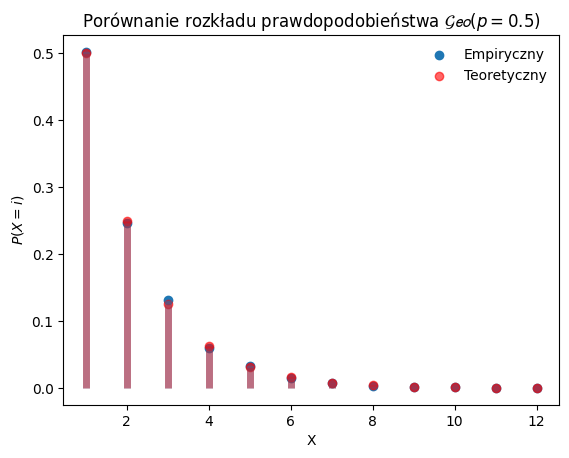

In [949]:
visualize_pmf(X, N, pk, k, name)

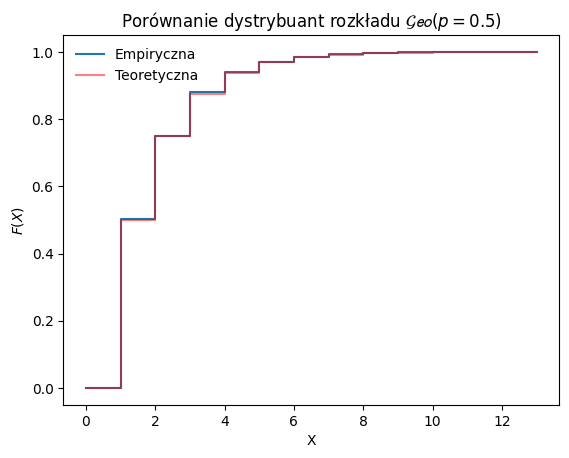

In [950]:
visualize_cdf_disrete(X, N, pk, name)

In [951]:
print(f"Empiryczna wartość oczekiwana rozkładu: {np.mean(X)}")
print(f"Teoretyczna wartość oczekiwana rozkładu: {1/p}")

Empiryczna wartość oczekiwana rozkładu: 1.9864
Teoretyczna wartość oczekiwana rozkładu: 2.0


In [952]:
print(f'Empiryczna wariancja rozkładu: {np.var(X)}')
print(f'Teoretyczna wariancja rozkładu: {(1 - p)/p**2}')

Empiryczna wariancja rozkładu: 1.9096150400000003
Teoretyczna wariancja rozkładu: 2.0


In [953]:
print(f'Skośność rozkładu obliczona ze wzoru: {skewness(X)}')
print(f'Skośność rozkładu obliczona przy pomocy wbudowanej funkcji: {stats.skew(X)}')

Skośność rozkładu obliczona ze wzoru: 2.0168123831239493
Skośność rozkładu obliczona przy pomocy wbudowanej funkcji: 2.0168123831239435


In [954]:
print(f'Kurtoza rozkładu obliczona ze wzoru: {kurtosis(X)}')
print(f'Kurtoza rozkładu obliczona przy pomocy wbudowanej funkcji: {stats.kurtosis(X)}')

Kurtoza rozkładu obliczona ze wzoru: 5.5222814482008165
Kurtoza rozkładu obliczona przy pomocy wbudowanej funkcji: 5.522281448202067


**Wnioski:** 

Możemy zauważyć, że wygenerowana przez nas realizacja zmiennej losowej jest zbliżona do zmiennej losowej z rozkładu geometrycznego. Teoretyczne rozkłady prawdopodobieństw pokrywają się z tymi wysymulowanymi, podobnie jest w przypadku wykresu dystrybuant: teoretycznej i empirycznej. 
Widzimy również, że teoretyczne i empiryczne: wartości oczekiwane ($EX$) oraz wariancje ($Var(X)$) są do siebie bardzo zbliżone.

Analizując wartość współczynnika skośności $\approx 2.02 > 0 $ możemy stwierdzić, że rozkład jest prawostronnie skośny, natomiast patrząc na wartość kurtozy $\approx 5.52 > 0$ widzimy, że rozkład ten jest ciężkoogonowy.

Wnioski te potwierdza kształt wykresu gęstości oraz wiedza o własnościach rozkładu geometrycznego.

#### **PRZYKŁAD 2 - rozkład Poissona**
Chcemy generować zmienną losową X z rozkładu Poissona: $ X \sim \mathcal{P}(\lambda)$, gdzie $\lambda>0$. 
$$ p_n = P(X=n) = \mathrm{e} ^ {-\lambda} \ast \frac{\lambda^n}{n!}, \ \ \ \ \ p_{n+1} = p_n \frac{\lambda}{n+1}, \ \ \ \ \ n \in \mathbb{N_0} $$ 

Dla rozkładu $\mathcal{P}(\lambda)$ teoretyczne wartości charakterystyk wynoszą:
- wartość oczekiwana: $ EX = \lambda, $
- wariancja: $ Var(X) = \lambda. $

**Algorytm dla rozkładu $\mathcal{P}(\lambda)$:**
1. $ j=0 \ \ \ \ p = \mathrm{e} ^ {-\lambda} \ \ \ \ F = \sum_{j=1}^{n} p_j = p $.
2. Generuj $ U \sim U(0,1) $.
3. While $ U>F \\ $ 
$ \ \ \ \ p = p \frac{\lambda}{j+1} \\ $ 
$ \ \ \ \ F = F + p \\ $ 
$ \ \ \ \ j = j + 1 \\ $
end
4. Zwróć $ X = j $.


In [955]:
def inverse_poiss(lamb, n, size):

  u = np.random.random(size)

  p = np.exp(-lamb)
  cumulative_prob = p
  i = 0
  while np.any(u<1):
    if i == 0:
      u[u <= cumulative_prob] = n + 1
    elif i == 1:
      u[u <= cumulative_prob] = n + 2
    else:
      u[u <= cumulative_prob] = i
    
    p = (lamb * p)/(i + 1)
    cumulative_prob += p
    i += 1

  u[u == n+1] = 0
  u[u == n+2] = 1
  return u

In [956]:
lamb = 5
N = 10000
n = 20
X = inverse_poiss(lamb, n, N)
k  = np.arange(len(pmf(X, N)))
pk = [(lamb**k)/factorial(k)*np.exp(-lamb) for k in range(len(pmf(X, N)))]
name = "$\mathcal{P} (\lambda = 5)$"

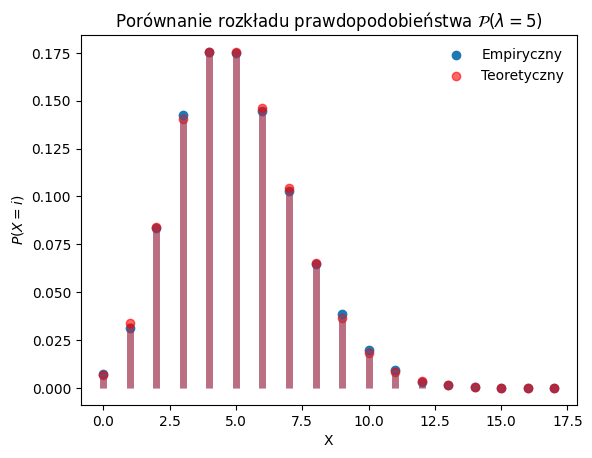

In [957]:
visualize_pmf(X, N, pk, k, name)

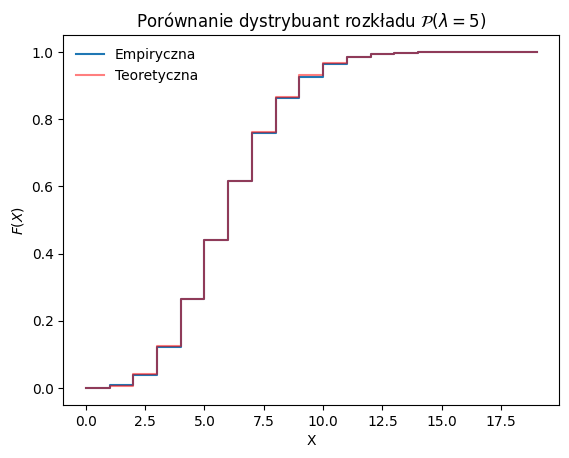

In [958]:
visualize_cdf_disrete(X, N, pk, name)

In [959]:
print(f"Empiryczna wartość oczekiwana rozkładu: {np.mean(X)}")
print(f"Teoretyczna wartość oczekiwana rozkładu: {lamb}")

Empiryczna wartość oczekiwana rozkładu: 5.0242
Teoretyczna wartość oczekiwana rozkładu: 5


In [960]:
print(f'Empiryczna wariancja rozkładu: {np.var(X)}')
print(f'Teoretyczna wariancja rozkładu: {lamb}')

Empiryczna wariancja rozkładu: 5.0962143599999985
Teoretyczna wariancja rozkładu: 5


In [961]:
print(f'Skośność rozkładu obliczona ze wzoru: {skewness(X)}')
print(f'Skośność rozkładu obliczona przy pomocy wbudowanej funkcji: {stats.skew(X)}')

Skośność rozkładu obliczona ze wzoru: 0.4740017532984239
Skośność rozkładu obliczona przy pomocy wbudowanej funkcji: 0.47400175329850486


In [962]:
print(f'Kurtoza rozkładu obliczona ze wzoru: {kurtosis(X)}')
print(f'Kurtoza rozkładu obliczona przy pomocy wbudowanej funkcji: {stats.kurtosis(X)}')

Kurtoza rozkładu obliczona ze wzoru: 0.24677991726927884
Kurtoza rozkładu obliczona przy pomocy wbudowanej funkcji: 0.2467799172704277


**Wnioski:** 

Możemy zauważyć, że wygenerowana przez nas realizacja zmiennej losowej jest zbliżona do zmiennej losowej z rozkładu Poissona. Teoretyczne rozkłady prawdopodobieństw pokrywają się z tymi wysymulowanymi, podobnie jest w przypadku wykresu dystrybuant: teoretycznej i empirycznej. 
Widzimy również, że teoretyczne i empiryczne: wartości oczekiwane ($EX$) oraz wariancje ($Var(X)$) są do siebie bardzo zbliżone.

Analizując wartość współczynnika skośności $\approx 0.47 > 0$ możemy stwierdzić, że rozkład jest prawostronnie skośny, natomiast patrząc na wartość kurtozy $\approx 0.25 > 0$ widzimy, że rozkład ten jest ciężkoogonowy.


Wnioski te potwierdza kształt wykresu gęstości oraz wiedza o własnościach rozkładu Poissona.

- ### **Metoda odwracania dystrybuanty - rozkłady ciągłe:**
Chcemy wygenerować realizację zmiennej losowej X o dystrybuancie $F_X(x) $.

Istnieją dwa przypadki: gdy dystrybuanta jest ściśle rosnąca oraz gdy nie jest ściśle rosnąca.


#### **Algorytm ogólny** - dystrybuanta jest ściśle rosnąca:
1. Wyznacz $ F_X ^ {-1}(x) $.
2. Generuj $ U \sim U(0,1) $.
3. Wstaw $ F_X ^ {-1}(U) $

#### **Algorytm ogólny** - dystrybuanta nie jest ściśle rosnąca:
Definiujemy dystrybuantę tzw. "uogólnioną odwrotną":
$ \ \ \~{F_X} ^ {-1}(y) \stackrel{def}{=} inf \ \{ x \in \mathbb{R}: F_X(x) \geqslant y \} . \\ $
Wtedy $ \~{F_X} ^ {-1}(U) \stackrel{d}{=} X $

Następnie stosujemy poniższy algorytm:
1. Generuj $ U \sim U(0,1) $.
2. Wstaw $ \~{F_X} ^ {-1}(U) $

#### **PRZYKŁAD 1 - rozkład Pareto**
Chcemy generować zmienną losową X z rozkładu Pareto: $ X \sim \mathcal{Pareto}(\alpha, x_{m}), x_{m}>0, \alpha>0$.

Dystrybuanta tego rozkładu ma postać:  $ F_X (x) = \begin{cases} 1 - (\frac{x_m}{x})^\alpha \ \ \ \ x \geqslant x_m \\ 0 \ \ \ \ \ \ \ \ \ \ \ \ \ \ \ \ \ \ \ x < x_m \end{cases} $.

Dla rozkładu $\mathcal{Pareto}(\alpha, x_{m})$ teoretyczne wartości charakterystyk wynoszą:
- wartość oczekiwana: $ EX = \frac{\alpha \ast x_m}{\alpha - 1}, $
- wariancja: $ Var(X) = \frac{\alpha}{\alpha - 2} \ast (\frac{x_m}{\alpha - 1})^2. $

Widzimy, że powyższa dystrybuanta jest ściśle rosnąca, więc zajmiemy się teraz znalezieniem dystrybuanty odwrotnej. Skupimy się na przedziale $x \geqslant x_m$, ponieważ poza tym przedziałem dystrybuanta jest równa 0:

$$ y = 1 - (\frac{x_m}{x})^\alpha $$
$$ (\frac{x_m}{x})^\alpha = 1-y $$
$$ \frac{x_m}{x} = \sqrt[\alpha]{1-y} $$
$$ x = \frac {x_m}{(1-y)^\frac{1}{\alpha}} $$

Czyli odwrotna dystrybuanta ma postać:
$$ {F_X} ^ {-1}(y) = \frac {x_m}{(1-y)^\frac{1}{\alpha}} \stackrel{d}{=} \frac {x_m}{y^\frac{1}{\alpha}} $$


**Algorytm dla rozkładu $\mathcal{Pareto}(\alpha, x_{m})$:**
1. Generuj $ U \sim U(0,1) $.
2. Wstaw $ {F_X} ^ {-1}(U) = \frac {x_m}{U^\frac{1}{\alpha}} $

In [963]:
def inverse_pareto(alpha, x_m, size):
    U = np.random.uniform(0, 1, size)
    result = x_m/(U)**(1/alpha)
    return result

In [964]:
x_m = 1
alpha = 10
N = 1000
X = inverse_pareto(alpha, x_m, N)
x = np.linspace(x_m, 3, N)
f_th = (alpha*x_m**alpha)/x**(alpha + 1) 
F_th = 1 - (x_m/x)**alpha 
name = "$\mathcal{Pareto}(\\alpha = 10, x_{m} = 1)$"

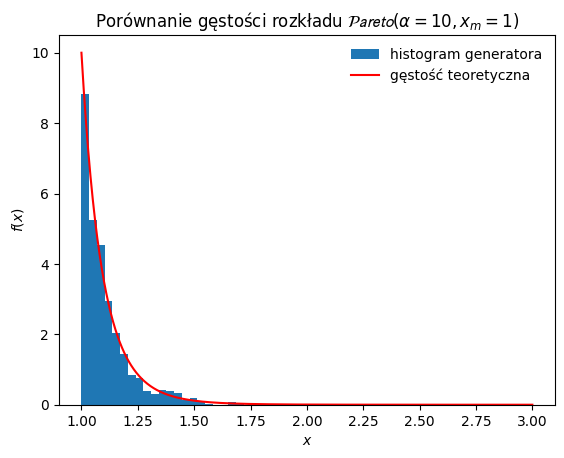

In [965]:
visualize_pdf(X, f_th, x, name)

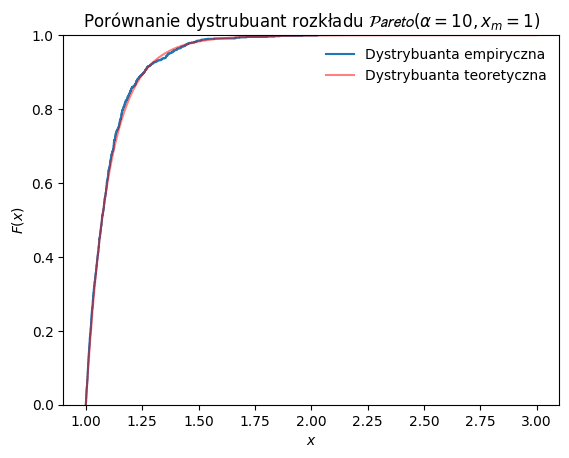

In [966]:
visualize_cdf(X, F_th, x, name)

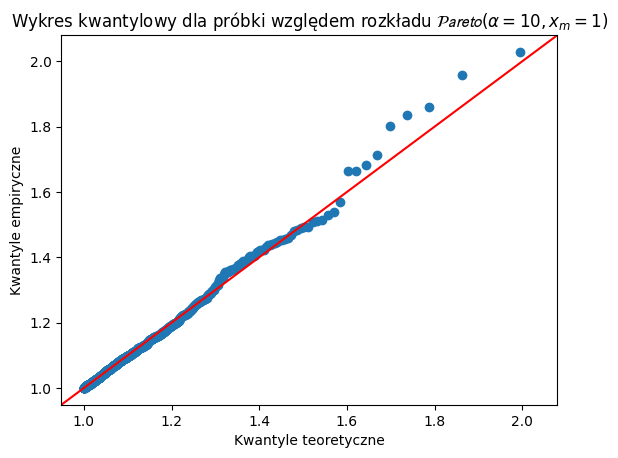

In [967]:
quantiles(X, stats.pareto(alpha), name)

In [968]:
print(f"Empiryczna wartość oczekiwana rozkładu: {np.mean(X)}")
print(f"Teoretyczna wartość oczekiwana rozkładu: {alpha*x_m/(alpha - 1)}")

Empiryczna wartość oczekiwana rozkładu: 1.109512971243712
Teoretyczna wartość oczekiwana rozkładu: 1.1111111111111112


In [969]:
print(f'Empiryczna wariancja rozkładu: {np.var(X)}')
print(f'Teoretyczna wariancja rozkładu: {(alpha/(alpha - 2))*(x_m/(alpha - 1))**2}')

Empiryczna wariancja rozkładu: 0.01564403589834679
Teoretyczna wariancja rozkładu: 0.015432098765432098


In [970]:
print(f'Skośność rozkładu obliczona ze wzoru: {skewness(X)}')
print(f'Skośność rozkładu obliczona przy pomocy wbudowanej funkcji: {stats.skew(X)}')

Skośność rozkładu obliczona ze wzoru: 2.619098516773256
Skośność rozkładu obliczona przy pomocy wbudowanej funkcji: 2.6190985167732537


In [971]:
print(f'Kurtoza rozkładu obliczona ze wzoru: {kurtosis(X)}')
print(f'Kurtoza rozkładu obliczona przy pomocy wbudowanej funkcji: {stats.kurtosis(X)}')

Kurtoza rozkładu obliczona ze wzoru: 10.044742735554982
Kurtoza rozkładu obliczona przy pomocy wbudowanej funkcji: 10.044742735554953


**Wnioski:** 

Możemy zauważyć, że wygenerowana przez nas realizacja zmiennej losowej jest zbliżona do zmiennej losowej z rozkładu Pareto. Gęstość teoretyczna pokrywa się z histogramem wysymulowanych wartości, podobnie jest w przypadku wykresu dystrybuant oraz kwantyli: teoretycznych i empirycznych. 
Widzimy również, że teoretyczne i empiryczne: wartości oczekiwane ($EX$) oraz wariancje ($Var(X)$) są do siebie bardzo zbliżone.

Analizując wartość współczynnika skośności $\approx 2.62 > 0$ możemy stwierdzić, że rozkład jest prawostronnie skośny, natomiast patrząc na wartość kurtozy $\approx 10.04 > 0$ widzimy, że rozkład ten jest ciężkoogonowy.

Wnioski te potwierdza kształt wykresu gęstości oraz wiedza o własnościach rozkładu Pareto.

#### **PRZYKŁAD 2 - rozkład Weibulla**
Chcemy generować zmienną losową X z rozkładu Weibulla: $ X \sim \mathcal{Weibull}(\lambda, p), \lambda > 0, p > 0$.

Dystrybuanta tego rozkładu ma postać:  $ F_X (x) = \begin{cases} 0 \ \ \ \ \ \ \ \ \ \ \ \ \ \ \ \ \ \ \ \ \ x \leqslant 0\\ 1 - \mathrm{e} ^ {-(\lambda x)^p}\ \ \ \ \ x > 0 \end{cases} $

Dla rozkładu $\mathcal{Weibull}(\lambda, p)$ teoretyczne wartości charakterystyk wynoszą:
- wartość oczekiwana: $ EX = \Gamma(1 + \frac{1}{p}) \ast \frac{1}{\lambda}, $
- wariancja: $ Var(X) = (\Gamma(1 + \frac{2}{p}) - \Gamma(1 + \frac{1}{p})^2) \ast \frac {1}{\lambda^2}. $

Widzimy, że powyższa dystrybuanta jest ściśle rosnąca, więc zajmiemy się teraz znalezieniem dystrybuanty odwrotnej. Skupimy się na przedziale $x > 0 $, ponieważ poza tym przedziałem dystrybuanta jest równa 0:

$$ y = 1 - \mathrm{e} ^ {-(\lambda x)^p} $$
$$ \mathrm{e} ^ {-(\lambda x)^p} = 1-y $$
$$ -(\lambda x)^p = \ln{1-y} $$
$$ (\lambda x)^p = -\ln{1-y}  $$
$$ \lambda x = \sqrt[p]{ -\ln{1-y}} $$
$$ x = \frac{1}{\lambda} \ast ({ -\ln(1-y)}) ^ {\frac{1}{p}} $$

Czyli dystrybuanta odwrotna ma postać:
$$ {F_X} ^ {-1}(y) = \frac{1}{\lambda} \ast ({ -\ln(1-y)}) ^ {\frac{1}{p}} \stackrel{d}{=} \frac{1}{\lambda} \ast ({ -\ln(y)}) ^ {\frac{1}{p}}$$ 

**Algorytm dla rozkładu $\mathcal{Weibull}(\lambda, p)$:**
1. Generuj $ U \sim U(0,1) $.
2. Wstaw $ {F_X} ^ {-1}(U) = \frac{1}{\lambda} \ast ({ -\ln(U)}) ^ {\frac{1}{p}} $

In [972]:
def inverse_weibull(lamb, p, size):
    U = np.random.uniform(0, 1, size)
    result = (1/lamb)*(-np.log(U))**(1/p)
    return result

In [973]:
lamb = 1/2
p = 2
N = 1000
X = inverse_weibull(lamb, p, N)
x = np.linspace(0, 6, N)
f_th = lamb*p*((lamb*x)**(p-1))*np.exp(-(lamb*x)**p)
F_th = 1 - np.exp(-(lamb*x)**p) #wzór ogólny
name = "$\mathcal{W}(\lambda = \\frac{1}{2}, p = 2)$" 

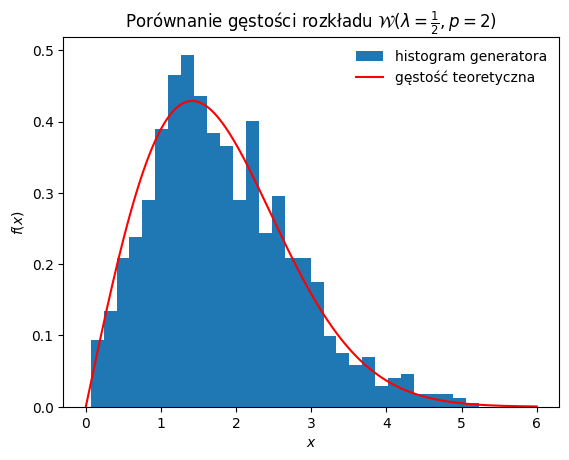

In [974]:
visualize_pdf(X, f_th, x, name)

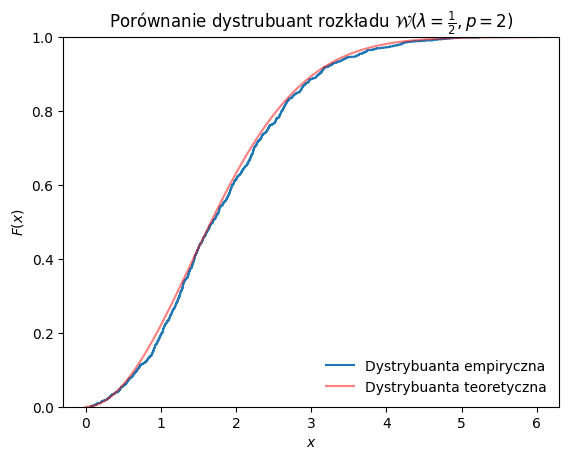

In [975]:
visualize_cdf(X, F_th, x, name)

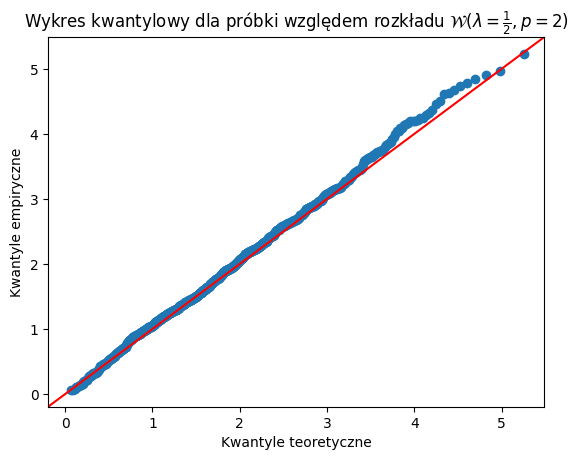

In [976]:
quantiles(X, stats.weibull_min(p, scale = 1/lamb), name)

In [977]:
print(f"Empiryczna wartość oczekiwana rozkładu: {np.mean(X)}")
print(f"Teoretyczna wartość oczekiwana rozkładu: {special.gamma(1 + 1/p)/lamb}")

Empiryczna wartość oczekiwana rozkładu: 1.8233205125173466
Teoretyczna wartość oczekiwana rozkładu: 1.7724538509055159


In [978]:
print(f'Empiryczna wariancja rozkładu: {np.var(X)}')
print(f'Teoretyczna wariancja rozkładu: {(special.gamma(1 + 2/p) - special.gamma(1 + 1/p)**2)/lamb**2}')

Empiryczna wariancja rozkładu: 0.8928129601961734
Teoretyczna wariancja rozkładu: 0.8584073464102073


In [979]:
print(f'Skośność rozkładu obliczona ze wzoru: {skewness(X)}')
print(f'Skośność rozkładu obliczona przy pomocy wbudowanej funkcji: {stats.skew(X)}')

Skośność rozkładu obliczona ze wzoru: 0.6451230358649576
Skośność rozkładu obliczona przy pomocy wbudowanej funkcji: 0.645123035864957


In [980]:
print(f'Kurtoza rozkładu obliczona ze wzoru: {kurtosis(X)}')
print(f'Kurtoza rozkładu obliczona przy pomocy wbudowanej funkcji: {stats.kurtosis(X)}')

Kurtoza rozkładu obliczona ze wzoru: 0.22087176645869588
Kurtoza rozkładu obliczona przy pomocy wbudowanej funkcji: 0.22087176645870032


**Wnioski:** 

Możemy zauważyć, że wygenerowana przez nas realizacja zmiennej losowej jest zbliżona do zmiennej losowej z rozkładu Weibulla. Gęstość teoretyczna pokrywa się z histogramem wysymulowanych wartości, podobnie jest w przypadku wykresu dystrybuant oraz kwantyli: teoretycznych i empirycznych.  
Widzimy również, że teoretyczne i empiryczne: wartości oczekiwane ($EX$) oraz wariancje ($Var(X)$) są do siebie bardzo zbliżone.

Analizując wartość współczynnika skośności $\approx 0.65 > 0$ możemy stwierdzić, że rozkład jest prawostronnie skośny, natomiast patrząc na wartość kurtozy $\approx 0.22 > 0$ widzimy, że rozkład ten jest ciężkoogonowy.

Wnioski te potwierdza kształt wykresu gęstości oraz wiedza o własnościach rozkładu Weibulla.

- ### **Metoda akceptacji-odrzucenia - rozkłady dyskretne:**

Chcemy generować zmienną losową X o rozkładzie dyskretnym: $$ \\ p_i = P(X=i), \ \ \ \ \ i = 1,2,..., \ \ \ \ \  p_i \geqslant 0, \ \ \ \ \  \sum_{i=1}^{n} p_i = 1 .$$

Zakładamy, że:
1. Potrafimy (efektywnie) generować realizację innej zmiennej losowej Y o rozkładzie $ q_i = P(Y=i), \ \ i = 1,2,..., \ \  q_i \geqslant 0, \ \ \sum_{i=1}^{n} q_i = 1. \\ $
Zbiory wartości X i Y muszą być takie same.
2. Istnieje stała $ 0 < c < \infty $, taka, że $ \max_{i}  \frac{p_i}{q_i} \leqslant c. $

#### **Algorytm ogólny**:
1. Generuj $Y$.
2. Generuj $ U \sim U(0,1), \ \ U \bot Y$
3. Jeśli $ U \leqslant \frac{p_Y}{c \ast q_Y} $ zwróć $ X = Y. \\ $ W przeciwnym razie wróć do 1.

Każdą pojedynczą iterację algorytmu możemy traktować jak próbę Bernoulliego, dlatego prawdopodobieństwo, że zmienna zostanie zaakceptowana wynosi $ \frac{1}{c}, \ \ c \geqslant 1 $.

Liczba powtórzeń algorytmu ma rozkład geometryczny, dla którego prawdopodobieństwo sukcesu wynosi $ \frac {1}{p} $. W związku z tym, średnia liczba powtórzeń naszego algorytmu wynosi $ \frac{1}{\frac{1}{c}} = c$.

Chcemy, żeby algorytm był jak najbardziej wydajny, dlatego stała $ c $ powinna być jak najmniejsza.


#### **PRZYKŁAD 1 - rozkład dyskretny o skokach: $ P(X=i) = \begin{cases} 0.10, \ \ dla \ i = 1 \\ 0.17, \ \ dla \ i = 2 \\ 0.23, \ \ dla \ i = 3 \\ 0.23, \ \ dla \ i = 4 \\ 0.17, \ \ dla \ i = 5 \\ 0.10, \ \ dla \ i = 6 \end{cases} .$**

Dla naszego rozkładu dyskretnego teoretyczne wartości charakterystyk wynoszą:
- wartość oczekiwana: $ EX =  \sum_{i=1}^{n} (p_i \ast x_i), $
- wariancja: $ Var(X) = \sum _{i=1}^{n} (p_i \ast x_i^2)  - EX^2. $

Zakładamy, że potrafimy efektywnie generować zmienną losową $Y$ o rozkładzie: $P(Y=1) = P(Y=2) = P(Y=3) = P(Y=4) = P(Y=5) = P(Y=6) = \frac{1}{6} $.

Zanim przejdziemy do algorytmu wyznaczymy najpierw stałą $c$:
$$ c = \max_i \frac{p_i}{q_i} = 6 \ast \max_i p_i = 6 \ast 0.23 = 1.38 $$ 
Wartość ta jest zgodna z tą, która została obliczona numerycznie i wykorzystana w generatorze.

**Algorytm dla naszego rozkładu dyskretnego**
1. Generuj $ U_1 \sim U(0,1)$, wstaw $Y = \left \lceil 6 \ast U_1 \right \rceil $.
2. Generuj $ U \sim U(0,1), \ \ U \bot U_1 $.
3. Jeśli $ U_2 \leqslant \frac {p_Y}{c \ast q_Y} = \frac{23}{100} \ast p_Y$ zwróć $ X= Y. \\ $ W przeciwnym razie wróć do punktu 1.


In [981]:
def discrete_acceptance_rejection_method(lst, size):
    n = len(lst)
    result = []

    for i in range(size):

        end = False
        while not end:
            U_1 = np.random.uniform(0, 1)
            Y = ceil(n*U_1)
            U_2 = np.random.uniform(0, 1)

            if U_2 <= lst[Y - 1] * 23/100:
                result.append(Y)
                end = True
                
    return np.array(result)

In [982]:
p = [0.10, 0.17, 0.23, 0.23, 0.17, 0.10]
k = np.arange(1, len(p) + 1)
N = 10000
name = "$P(X = 1) = P(X = 6) = 0.10,$\n $P(X = 2) = P(X = 5) = 0.17, P(X = 3) = P(X = 4) = 0.23$"

In [983]:
X = discrete_acceptance_rejection_method(p, N)

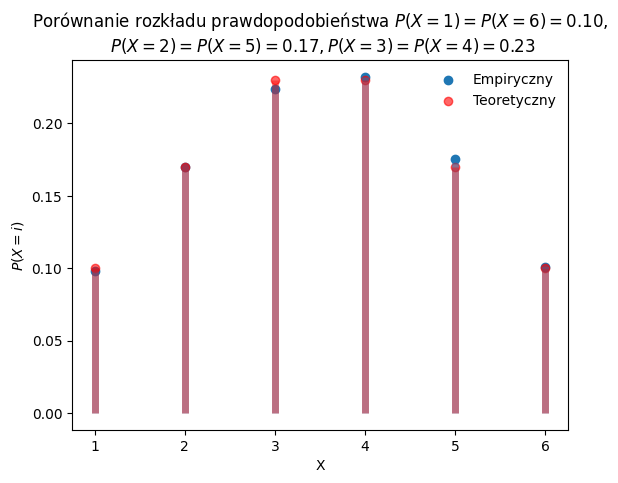

In [984]:
visualize_pmf(X, N, p, k, name)

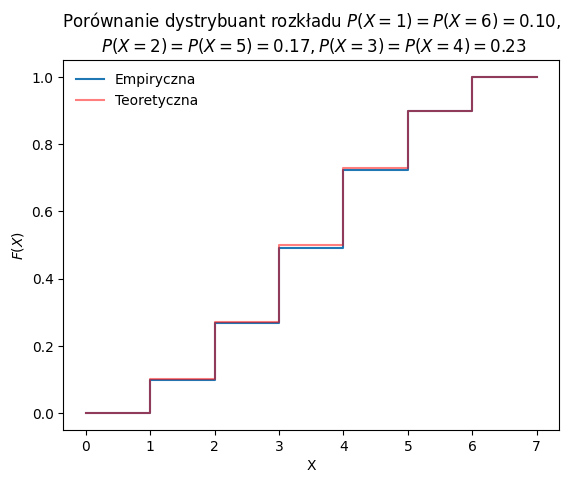

In [985]:
visualize_cdf_disrete(X, N, p, name)

In [986]:
print(f"Empiryczna wartość oczekiwana rozkładu: {np.mean(X)}")
print(f"Teoretyczna wartość oczekiwana rozkładu: {sum([p[i] * (i+1) for i in range(len(p))])}")

Empiryczna wartość oczekiwana rozkładu: 3.5185
Teoretyczna wartość oczekiwana rozkładu: 3.5000000000000004


In [987]:
print(f'Empiryczna wariancja rozkładu: {np.var(X)}')
print(f'Teoretyczna wariancja rozkładu: {sum([p[i] * (i+1)**2 for i in range(len(p))]) - sum([p[i] * (i+1) for i in range(len(p))])**2}')

Empiryczna wariancja rozkładu: 2.13325775
Teoretyczna wariancja rozkładu: 2.1299999999999972


In [988]:
print(f'Skośność rozkładu obliczona ze wzoru: {skewness(X)}')
print(f'Skośność rozkładu obliczona przy pomocy wbudowanej funkcji: {stats.skew(X)}')

Skośność rozkładu obliczona ze wzoru: -0.018607660146895855
Skośność rozkładu obliczona przy pomocy wbudowanej funkcji: -0.018607660146892385


In [989]:
print(f'Kurtoza rozkładu obliczona ze wzoru: {kurtosis(X)}')
print(f'Kurtoza rozkładu obliczona przy pomocy wbudowanej funkcji: {stats.kurtosis(X)}')

Kurtoza rozkładu obliczona ze wzoru: -0.9025592426764124
Kurtoza rozkładu obliczona przy pomocy wbudowanej funkcji: -0.9025592426766047


**Wnioski:** 

Możemy zauważyć, że wartości prawdopodobieństw dla wygenerowanej przez nas realizacji zmiennej losowej są zbliżone do teoretycznych wartości, podobnie jest w przypadku wykresu dystrybuant: teoretycznej i empirycznej. 

Widzimy również, że teoretyczne i empiryczne: wartości oczekiwane ($EX$) oraz wariancje ($Var(X)$) są do siebie bardzo zbliżone.

Analizując wartość współczynnika skośności $\approx - 0.02 \sim 0$ możemy stwierdzić, że nasz rozkład jest symetryczny, natomiast patrząc na wartość kurtozy $\approx -0.90 < 0$ widzimy, że rozkład ten jest lekkoogonowy.

Wnioski te potwierdza kształt wykresu gęstości.

#### **PRZYKŁAD 2 - rozkład Poissona**
Chcemy generować zmienną losową X z rozkładu Poissona: $ X \sim \mathcal{P}(\lambda)$, gdzie $\lambda>0$. 
$$ p_n = P(X=n) = \mathrm{e} ^ {-\lambda} \ast \frac{\lambda^n}{n!}, \ \ \ \ \ p_{n+1} = p_n \frac{\lambda}{n+1}, \ \ \ \ \ n \in \mathbb{N_0} $$ 

Dla rozkładu $\mathcal{P}(\lambda)$ teoretyczne wartości charakterystyk wynoszą:
- wartość oczekiwana: $ EX = \lambda, $
- wariancja: $ Var(X) = \lambda. $

Zakładamy, że potrafimy efektywnie generować zmienną losową $Y$ o rozkładzie $\mathcal{Geo}(p), 0 < p \leqslant 1$.

**Algorytm dla rozkładu $\mathcal{P}(\lambda)$:**
1. Generuj $Y = \mathcal{Geo}(p) -1 $.
2. Generuj $ U \sim U(0,1), \ \ U \bot Y$
3. Jeśli $ U \leqslant \frac{p_Y}{c \ast q_Y} $ zwróć $ X = Y. \\ $ W przeciwnym razie wróć do 1.

In [990]:
def poisson(lamb, k):
    result = (lamb**k)/factorial(k)*np.exp(-lamb)
    return result

def geo(p, k):
    result = p*(1 - p)**(k - 1)
    return result
    

def poisson_acceptance_rejection_method(lamb, p, k, size):
    result = []
    c = max([poisson(lamb, k) for k in range(k)]/geo(p, np.arange(1, k + 1))) 

    for _ in range(size):

        end = False
        while not end:
            Y = np.random.geometric(p) - 1
            U = np.random.uniform(0, 1)
            
            if U <= poisson(lamb, Y)/(c*geo(p, Y)):
                result.append(Y)
                end = True

    result = np.array(result)          
    return result

In [991]:
lamb = 5
N = 10000
p = 1/lamb
n = 10

In [992]:
X = poisson_acceptance_rejection_method(lamb, p, n, N)

In [993]:
k = np.arange(len(pmf(X, N)))
pk = [poisson(lamb, k) for k in range(len(pmf(X, N)))]
name = "$\mathcal{P} (\lambda = 5)$"

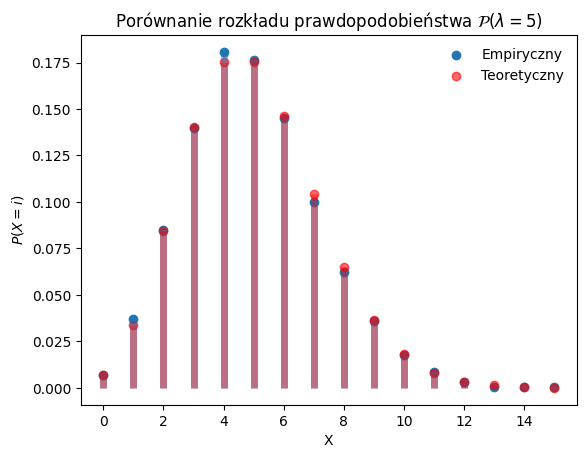

In [994]:
visualize_pmf(X, N, pk, k, name)

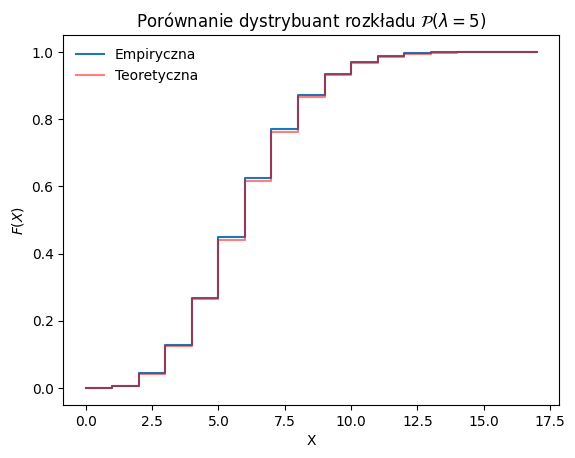

In [995]:
visualize_cdf_disrete(X, N, pk, name)

In [996]:
print(f"Empiryczna wartość oczekiwana rozkładu: {np.mean(X)}")
print(f"Teoretyczna wartość oczekiwana rozkładu: {lamb}")

Empiryczna wartość oczekiwana rozkładu: 4.9543
Teoretyczna wartość oczekiwana rozkładu: 5


In [997]:
print(f'Empiryczna wariancja rozkładu: {np.var(X)}')
print(f'Teoretyczna wariancja rozkładu: {lamb}')

Empiryczna wariancja rozkładu: 4.96521151
Teoretyczna wariancja rozkładu: 5


In [998]:
print(f'Skośność rozkładu obliczona ze wzoru: {skewness(X)}')
print(f'Skośność rozkładu obliczona przy pomocy wbudowanej funkcji: {stats.skew(X)}')

Skośność rozkładu obliczona ze wzoru: 0.4449917489841979
Skośność rozkładu obliczona przy pomocy wbudowanej funkcji: 0.4449917489842284


In [999]:
print(f'Kurtoza rozkładu obliczona ze wzoru: {kurtosis(X)}')
print(f'Kurtoza rozkładu obliczona przy pomocy wbudowanej funkcji: {stats.kurtosis(X)}')

Kurtoza rozkładu obliczona ze wzoru: 0.19125553128940842
Kurtoza rozkładu obliczona przy pomocy wbudowanej funkcji: 0.19125553128993822


**Wnioski:** 

Możemy zauważyć, że wygenerowana przez nas realizacja zmiennej losowej jest zbliżona do zmiennej losowej z rozkładu Poissona. Teoretyczne rozkłady prawdopodobieństw pokrywają się z tymi wysymulowanymi, podobnie jest w przypadku wykresu dystrybuant: teoretycznej i empirycznej. 
Widzimy również, że teoretyczne i empiryczne: wartości oczekiwane ($EX$) oraz wariancje ($Var(X)$) są do siebie bardzo zbliżone.

Analizując wartość współczynnika skośności $\approx 0.44 > 0$ możemy stwierdzić, że rozkład jest prawostronnie skośny, natomiast patrząc na wartość kurtozy $\approx 0.19 > 0$ widzimy, że rozkład ten jest ciężkoogonowy.

Wnioski te potwierdza kształt wykresu gęstości oraz wiedza o własnościach rozkładu Poissona.

- ### **Metoda akceptacji-odrzucenia - rozkład ciągły:**
Chcemy generować zmienną losową X o gęstości $ f(x) $.

#### **Algorytm ogólny**:
1. Generuj $Y$.
2. Generuj $U \sim U(0,1), U \bot Y $.
3. Jeśli $U \leqslant \frac{f(Y)}{c \ast g(Y)} $ zwróć $ X = Y .\\$ W przeciwnym razie wróć do punktu 1.


#### **PRZYKŁAD - rozkład Weibulla**

Chcemy generować zmienną losową X z rozkładu Weibulla: $ X \sim \mathcal{Weibull}(\lambda, p), \lambda > 0, p > 0$.
$$f(x) = \lambda \ast p ((\lambda \ast x)^{p-1}) \ast \mathrm{e}^{(-(\lambda \ast x)^p)} $$

Dla rozkładu $\mathcal{Weibull}(\lambda, p)$ teoretyczne wartości charakterystyk wynoszą:
- wartość oczekiwana: $ EX = \Gamma(1 + \frac{1}{p}) \ast \frac{1}{\lambda}, $
- wariancja: $ Var(X) = (\Gamma(1 + \frac{2}{p}) - \Gamma(1 + \frac{1}{p})^2) \ast \frac {1}{\lambda^2}. $

Zakładamy, że potrafimy efektywnie generować zmienną losową $Y$ o rozkładzie $\mathcal{Geo}(p), 0 < p \leqslant 1$. Y ma gęstość równą: $g(x) = \frac{1}{\lambda} \ast \mathrm{e}^{- \frac{1}{\lambda}x} $


**Algorytm dla rozkładu $\mathcal{Weibull}(\lambda, p)$:**
1. Generuj $Y \sim \mathcal{Exp}(\lambda)$.
2. Generuj $U \sim U(0,1), U \bot Y $
3. Jeśli $U \leqslant \frac{f(Y)}{c \ast g(Y)} $ zwróć $ X = Y $ ,  $f(Y) = \lambda \ast p ((\lambda \ast Y)^{p-1}) \ast \mathrm{e}^{(-(\lambda \ast Y)^p)} $, $g(Y) = \frac{1}{\lambda} \ast \mathrm{e}^{- \frac{1}{\lambda}Y} $. <br> W przeciwnym razie wróć do punktu 1.

In [1000]:
def weibull(lamb, p, x):
    result = lamb*p*((lamb*x)**(p-1))*np.exp(-(lamb*x)**p)
    return result

def expon(x, lamb):
    result = (1/lamb)*np.exp(-(1/lamb)*x)
    return result

def weibull_acceptance_rejection_method(lamb_1, lamb_2,  p, x, size):
    result = []
    c = max(weibull(lamb_1, p, x)/expon(x, lamb_2)) 

    for _ in range(size):

        end = False
        while not end:
            Y = np.random.exponential(lamb_2)
            U = np.random.uniform(0, 1)
            
            if U <= weibull(lamb_1, p, Y)/(c*expon(Y, lamb_2)):
                result.append(Y)
                end = True

    result = np.array(result)          
    return result

In [1001]:
lamb = 1/2
p = 2
lamb_exp = lamb/special.gamma(1 + 1/p) 
N = 1000
x = np.linspace(0, 6, N)

In [1002]:
X = weibull_acceptance_rejection_method(lamb, lamb, p, x, N)

In [1003]:
f_th = weibull(lamb, p, x)
F_th = 1 - np.exp(-(lamb*x)**p) #wzór ogólny
name = "$\mathcal{W}(\lambda = \\frac{1}{2}, p = 2)$" 

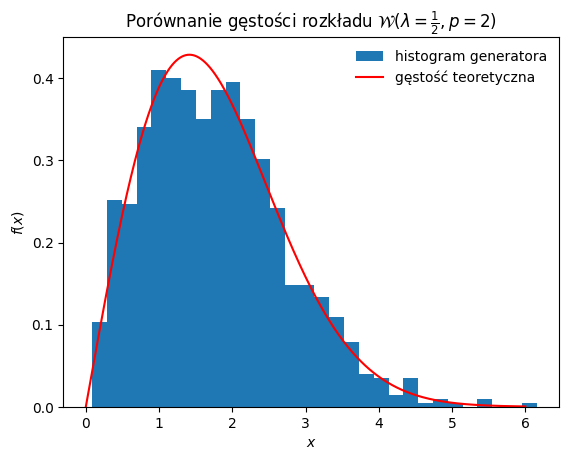

In [1004]:
visualize_pdf(X, f_th, x, name)

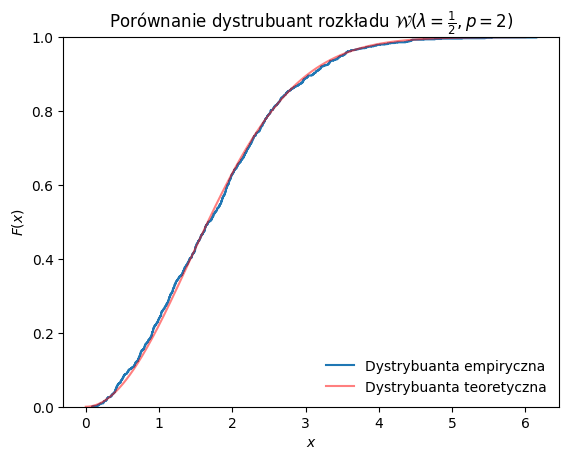

In [1005]:
visualize_cdf(X, F_th, x, name)

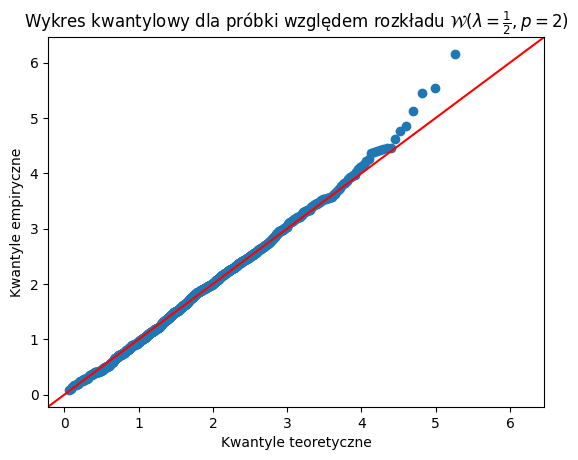

In [1006]:
quantiles(X, stats.weibull_min(p, scale = 1/lamb), name)

In [1007]:
print(f"Empiryczna wartość oczekiwana rozkładu: {np.mean(X)}")
print(f"Teoretyczna wartość oczekiwana rozkładu: {special.gamma(1 + 1/p)/lamb}")

Empiryczna wartość oczekiwana rozkładu: 1.7749065207389083
Teoretyczna wartość oczekiwana rozkładu: 1.7724538509055159


In [1008]:
print(f'Empiryczna wariancja rozkładu: {np.var(X)}')
print(f'Teoretyczna wariancja rozkładu: {(special.gamma(1 + 2/p) - special.gamma(1 + 1/p)**2)/lamb**2}')

Empiryczna wariancja rozkładu: 0.9236435289680767
Teoretyczna wariancja rozkładu: 0.8584073464102073


In [1009]:
print(f'Skośność rozkładu obliczona ze wzoru: {skewness(X)}')
print(f'Skośność rozkładu obliczona przy pomocy wbudowanej funkcji: {stats.skew(X)}')

Skośność rozkładu obliczona ze wzoru: 0.6949213517465959
Skośność rozkładu obliczona przy pomocy wbudowanej funkcji: 0.6949213517465936


In [1010]:
print(f'Kurtoza rozkładu obliczona ze wzoru: {kurtosis(X)}')
print(f'Kurtoza rozkładu obliczona przy pomocy wbudowanej funkcji: {stats.kurtosis(X)}')

Kurtoza rozkładu obliczona ze wzoru: 0.5220735861704009
Kurtoza rozkładu obliczona przy pomocy wbudowanej funkcji: 0.5220735861703885


**Wnioski:** 

Możemy zauważyć, że wygenerowana przez nas realizacja zmiennej losowej jest zbliżona do zmiennej losowej z rozkładu Weibulla. Gęstość teoretyczna pokrywa się z histogramem wysymulowanych wartości, podobnie jest w przypadku wykresu dystrybuant oraz kwantyli: teoretycznych i empirycznych. 
Widzimy również, że teoretyczne i empiryczne: wartości oczekiwane ($EX$) oraz wariancje ($Var(X)$) są do siebie bardzo zbliżone.

Analizując wartość współczynnika skośności $\approx 0.69 > 0$ możemy stwierdzić, że rozkład jest prawostronnie skośny, natomiast patrząc na wartość kurtozy $\approx 0.52 > 0$ widzimy, że rozkład ten jest ciężkoogonowy.

Wnioski te potwierdza kształt wykresu gęstości oraz wiedza o własnościach rozkładu Weibulla.

- ## **Metody generowania rozkładu normalnego**

In [1011]:
mi = 0
sigma = 1
N = 1000

x = np.linspace(-4, 4, N)
f_th = (1/(sigma*np.sqrt(2*np.pi)))*np.exp(-(1/2)*((x - mi)/sigma)**2)
F_th =  (1/2)*(1 + special.erf((x - mi)/(sigma*np.sqrt(2)))) #dystrybuante obliczyliśmy w programie wolfram, erf - funckcja błędu
name_X = "$\mathcal{N}(\mu = 0, \sigma = 1)$\ndla zmiennej losowej X" 
name_Y = "$\mathcal{N}(\mu = 0, \sigma = 1)$\ndla zmiennej losowej Y" 

- ### **Metoda Boxa-Mullera generowania rozkładu normalnego**
Jest to metoda służąca do generowania zmiennej losowej z rozkładu normalnego $\mathcal{N}(\mu, \sigma)$. Podczas generacji wykorzystujemy zmienne losowe z rozkład jednostajnego $\mathcal{U}(0,1)$.

Jeśli zmienna losowa $X_0 \sim \mathcal{N}(0,1)$, to zmienną losową $X \sim \mathcal{N}(\mu,\sigma)$ można zapisać w postaci:
$$ X \stackrel{d}{=} \sigma X_0 + \mu .$$

W naszym przypadku będziemy generować zmienne losowe ze standardowego rozkładu normalnego $\mathcal{N}(0,1)$.

#### **Algorytm**:
1. Generuj $U_1 \sim U(0,1), U_2 \sim U(0,1), U_1 \bot U_2 $.
2. Wstaw $ X = \sqrt{-2\ln{U_1}} \ast \cos{(2 \pi U_2)}$, $ Y = \sqrt{-2\ln{U_1}} \ast \sin{(2 \pi U_2)}$.
3. Zwróć $X, Y$.

In [1012]:
def box_muller_method(size, mi, sigma):
    U_1 = np.random.uniform(0, 1, size)
    U_2 = np.random.uniform(0, 1, size)

    X = np.sqrt(-2*np.log(U_1))* np.cos(2*np.pi*U_2)
    Y = np.sqrt(-2*np.log(U_1))* np.sin(2*np.pi*U_2)

    X = sigma*np.array(X) + mi 
    Y = sigma*np.array(Y) + mi

    #do porówanania lepiej( mamy porównywac algorytmy a nie metody dlatego mamy uzywac takich samych struktur):
    # X = []
    # Y = []
    # for i in range(size):
    #     U_1 = np.random.uniform(0, 1)
    #     U_2 = np.random.uniform(0, 1)

    #     x = np.sqrt(-2*np.log(U_1))* np.cos(2*np.pi*U_2)
    #     y = np.sqrt(-2*np.log(U_1))* np.sin(2*np.pi*U_2)

    #     X.append(sigma*x + mi)
    #     Y.append(sigma*y + mi)
    
    return X, Y

In [1013]:
X, Y = box_muller_method(N, mi, sigma)

(-6.0, 6.0)

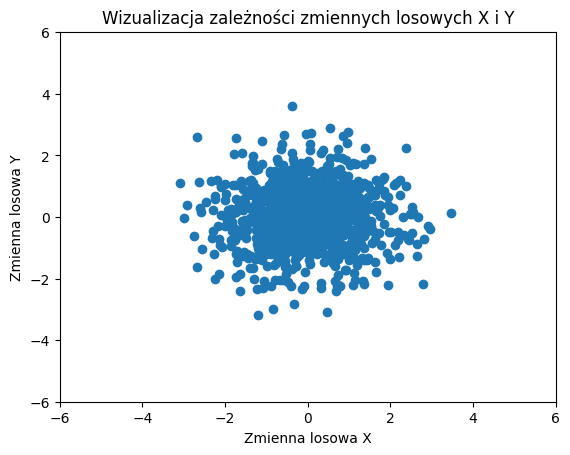

In [1014]:
plt.scatter(X, Y)
plt.title("Wizualizacja zależności zmiennych losowych X i Y")
plt.xlabel("Zmienna losowa X")
plt.ylabel("Zmienna losowa Y")
plt.xlim(-6, 6)
plt.ylim(-6, 6)

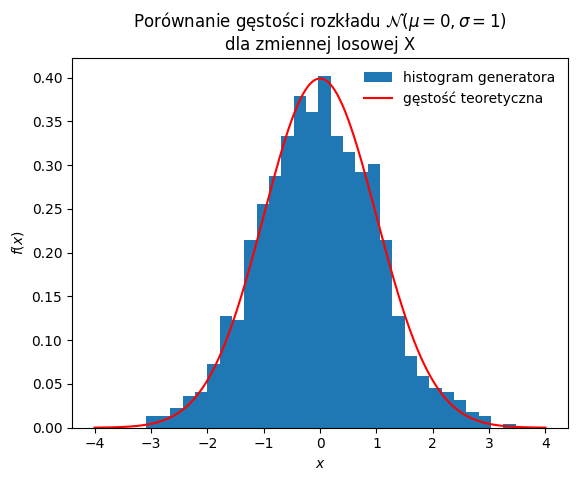

In [1015]:
visualize_pdf(X, f_th, x, name_X)

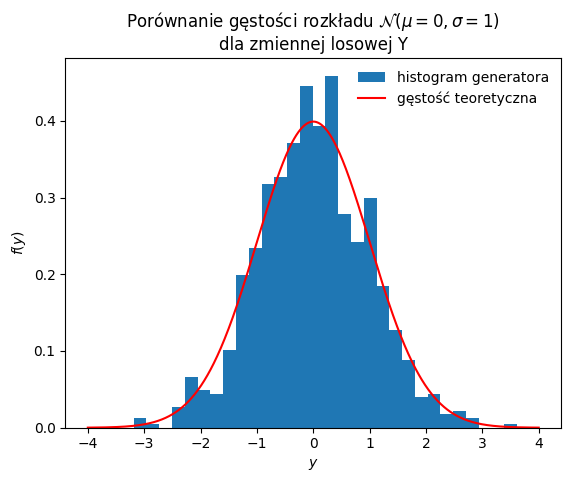

In [1016]:
visualize_pdf_Y(Y, f_th, x, name_Y)

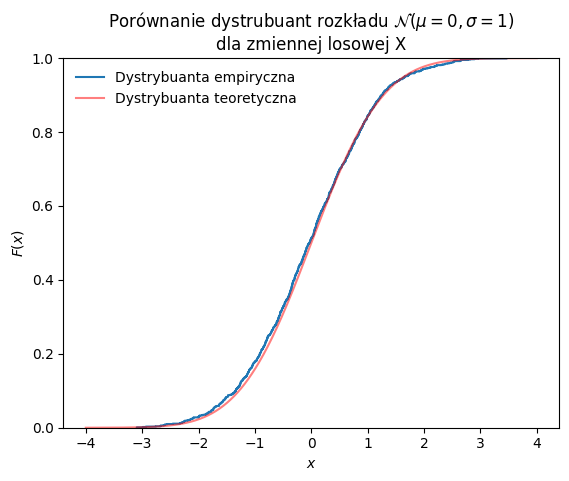

In [1017]:
visualize_cdf(X, F_th, x, name_X)

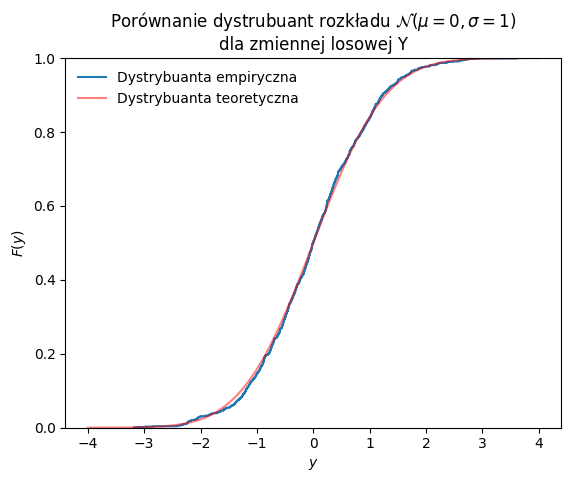

In [1018]:
visualize_cdf_Y(Y, F_th, x, name_Y)

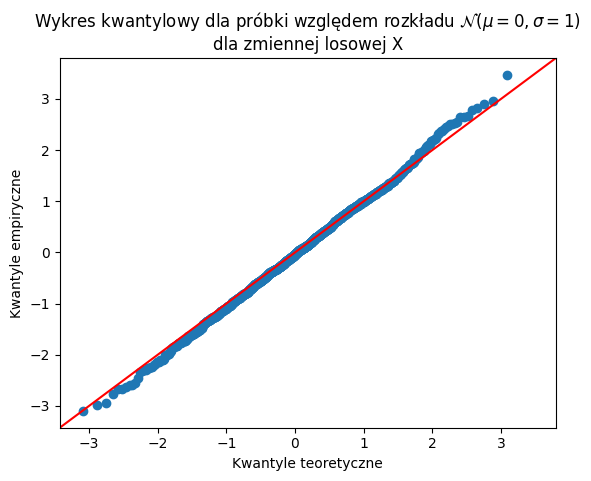

In [1019]:
quantiles(X, stats.norm(loc = mi, scale = sigma), name_X)

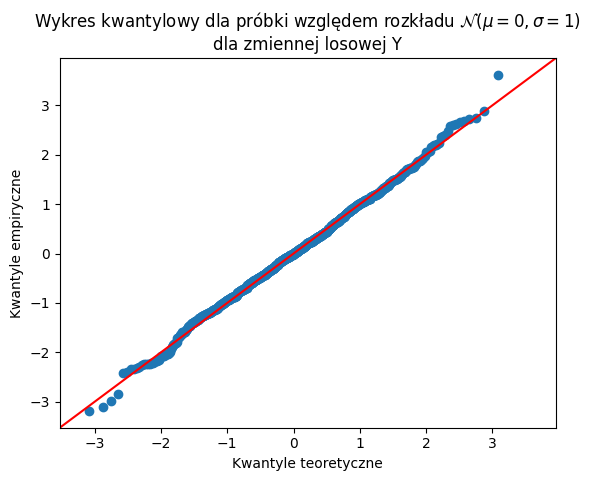

In [1020]:
quantiles(Y, stats.norm(loc = mi, scale = sigma), name_Y)

In [1021]:
print(f"Empiryczna wartość oczekiwana zmiennych losowych X i Y:   {np.mean(X)}  i  {np.mean(Y)}")
print(f"Teoretyczna wartość oczekiwana standardowego rozkładu normalnego: {mi}")

Empiryczna wartość oczekiwana zmiennych losowych X i Y:   -0.03230237832513259  i  0.009006916648873632
Teoretyczna wartość oczekiwana standardowego rozkładu normalnego: 0


In [1022]:
print(f"Empiryczna wariancja zmiennych losowych X i Y   {np.var(X)}  i  {np.var(Y)}")
print(f"Teoretyczna wariancja standardowego rozkładu normalnego: {sigma**2}")

Empiryczna wariancja zmiennych losowych X i Y   1.0891778963609318  i  0.9635578838911906
Teoretyczna wariancja standardowego rozkładu normalnego: 1


In [1023]:
print(f'Empiryczna skośność zmiennych losowych X i Y: {skewness(X)}  i  {skewness(Y)}')
print(f'Teoretyczna skośność standardowego rozkładu normalnego: {0}')

Empiryczna skośność zmiennych losowych X i Y: 0.047569382467086085  i  0.022627034890615225
Teoretyczna skośność standardowego rozkładu normalnego: 0


In [1024]:
print(f'Empiryczna kurtoza zmiennych losowych X i Y: {kurtosis(X)}  i  {kurtosis(Y)}')
print(f'Teoretyczna kurtoza standardowego rozkładu normalnego: {0}')

Empiryczna kurtoza zmiennych losowych X i Y: 0.008624383799974211  i  0.21640776622269486
Teoretyczna kurtoza standardowego rozkładu normalnego: 0


**Wnioski:**

Możemy zauważyć, że wygenerowane przez nas realizację zmiennych losowych są zbliżone do zmiennej losowej ze standardowego rozkładu normalnego. Gęstości teoretyczne zmiennych losowych X i Y pokrywają się z histogramami wysymulowanych wartości, podobnie jest w przypadku wykresów dystrybuant oraz kwantyli: teoretycznych i empirycznych. 
Widzimy również, że teoretyczne i empiryczne: wartości oczekiwane ($EX$), wariancje ($Var(X)$), skośności oraz kurtozy są do siebie bardzo zbliżone.

Dodatkowo, możemy zauważyć, że odpowiednie charakterystyki dla wysymulowanych zmiennych losowych X i Y nieznacznie się różnią. Pozwala to nam wnioskować, że $X \bot Y$, co potwierdza nasze założenia. Jednocześnie są one do siebie na tyle zbliżone, że widzimy, że obie zmienne losowe są z tego samego rozkładu.
Ponadto wykres zależności zmiennych losowych X i Y kształtem przypomina koło. 

- ### **Metoda biegunowa generowania rozkładu normalnego**

Metoda ta również służy do generowania zmiennej losowej z rozkładu normalnego $\mathcal{N}(\mu, \sigma)$. Powstaje ona w wyniku opisanych poniżej przekształceń metody Boxa-Mullera.

Na początku definiujemy wektor losowy $[V_1 = R \cos(\alpha), V_2 = R \sin(\alpha)]$ o rozkładzie jednostajnym w kole jednostkowym. Wykorzystamy go do pozbycia się funkcji trygonometrycznych wykorzystywanych w metodzie Boxa-Mullera. Dodatkowo wiemy, że ; $R \sim \mathcal{U}(0,1), \ \ \alpha \sim \mathcal{U}(0, 2 \pi),\ \ R \bot \alpha $.
<br> Z jedynki trygonometrycznej: $R^2 = V_1 ^2 + V_2 ^2, \ \ \ R^2 \sim \mathcal{U}(0,1)$.

Następnie do wzorów z metody Boxa-Mullera podstawimy: $ R^2 = U_1$ i $\alpha = 2 \pi U_2$

$$ X = \sqrt{-2\ln{{U}_{1}}} \ast \cos{(2 \pi {U}_{2})} = \sqrt{-2\ln{({R}^{2})}} \ast \cos{(\alpha)} = \sqrt{\frac{-2\ln{({R}^{2})}}{{R}^{2}}} \ast {V}_{1} $$


$$ X = \sqrt{-2\ln{{U}_{1}}} \ast \sin{(2 \pi {U}_{2})} = \sqrt{-2\ln{({R}^{2})}} \ast \sin{(\alpha)} = \sqrt{\frac{-2\ln{({R}^{2})}}{{R}^{2}}} \ast {V}_{2} $$

Wzory te będziemy wykorzystywać podczas generacji naszych zmiennych losowych.

#### **Algorytm**:
1. Generuj $V_1 \sim U(-1,1), V_2 \sim U(-1,1), V_1 \bot V_2 $.
2. Wyznacz $ R^2 = V_1 ^2 + V_2 ^2 $.
3. Jeśli $ R^2 > 1$ wróć do punktu 1.
4. Wstaw $ X = \sqrt{\frac{-2\ln{(R^2)}}{R^2}} \ast V_1 $, $ \ \ \ Y = \sqrt{\frac{-2\ln{(R^2)}}{R^2}} \ast V_2$.

In [1025]:
def polar_method(size, mi, sigma):
    X = []
    Y = []

    for _ in range(size):

        end = False
        while not end:
            V_1 = np.random.uniform(-1, 1)
            V_2 = np.random.uniform(-1, 1)

            R_squared = V_1**2 + V_2**2

            if R_squared <= 1:
                X.append(np.sqrt(-2*np.log(R_squared)/R_squared)* V_1)
                Y.append(np.sqrt(-2*np.log(R_squared)/R_squared)* V_2)
                end = True

    X = sigma*np.array(X) + mi 
    Y = sigma*np.array(Y) + mi

    return X, Y


In [1026]:
X, Y = polar_method(N, mi, sigma)

(-6.0, 6.0)

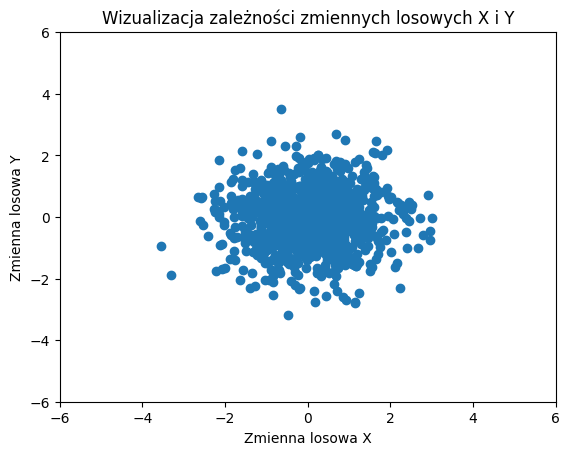

In [1027]:
plt.scatter(X, Y)
plt.title("Wizualizacja zależności zmiennych losowych X i Y")
plt.xlabel("Zmienna losowa X")
plt.ylabel("Zmienna losowa Y")
plt.xlim(-6, 6)
plt.ylim(-6, 6)

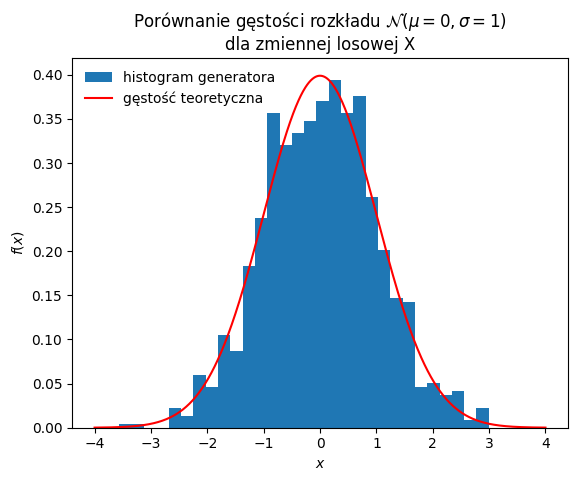

In [1028]:
visualize_pdf(X, f_th, x, name_X)

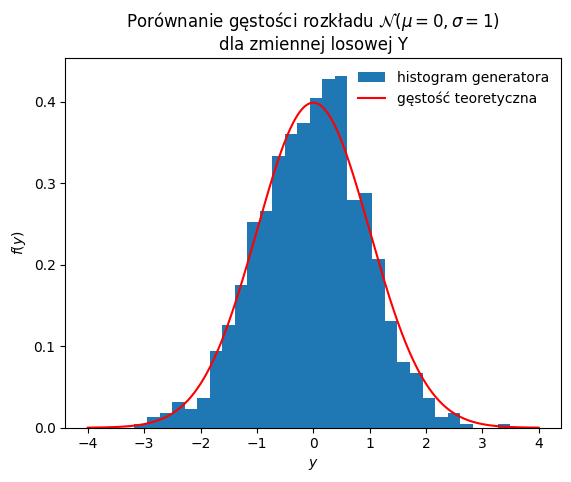

In [1029]:
visualize_pdf_Y(Y, f_th, x, name_Y)

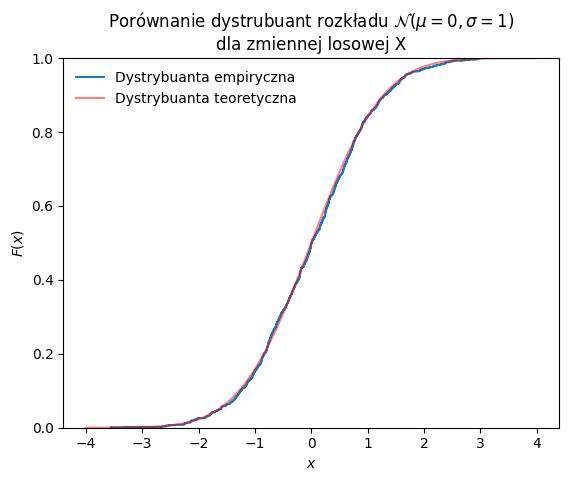

In [1030]:
visualize_cdf(X, F_th, x, name_X)

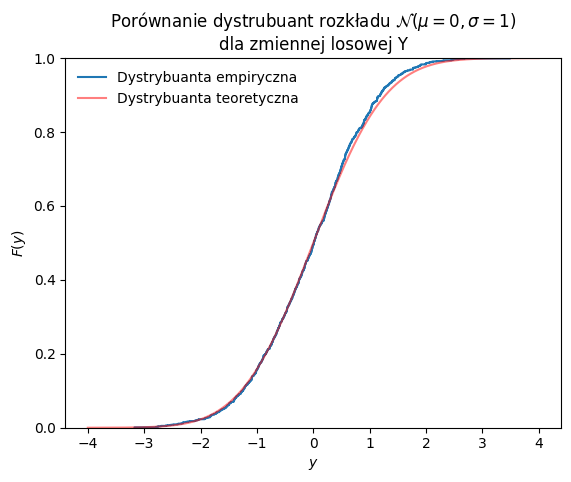

In [1031]:
visualize_cdf_Y(Y, F_th, x, name_Y)

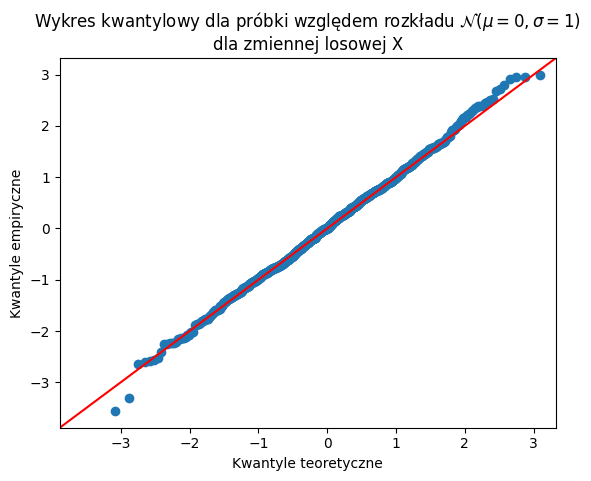

In [1032]:
quantiles(X, stats.norm(loc = mi, scale = sigma), name_X)

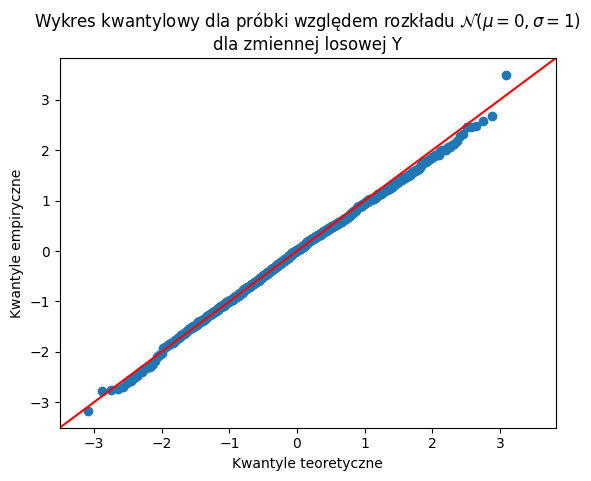

In [1033]:
quantiles(Y, stats.norm(loc = mi, scale = sigma), name_Y)

In [1034]:
print(f"Empiryczna wartość oczekiwana zmiennych losowych X i Y:   {np.mean(X)}  i  {np.mean(Y)}")
print(f"Teoretyczna wartość oczekiwana standardowego rozkładu normalnego: {mi}")

Empiryczna wartość oczekiwana zmiennych losowych X i Y:   0.02173220086595749  i  -0.02289188054177032
Teoretyczna wartość oczekiwana standardowego rozkładu normalnego: 0


In [1035]:
print(f"Empiryczna wariancja zmiennych losowych X i Y   {np.var(X)}  i  {np.var(Y)}")
print(f"Teoretyczna wariancja standardowego rozkładu normalnego: {sigma**2}")

Empiryczna wariancja zmiennych losowych X i Y   1.025144709711261  i  0.9206016916683155
Teoretyczna wariancja standardowego rozkładu normalnego: 1


In [1036]:
print(f'Empiryczna skośność zmiennych losowych X i Y: {skewness(X)}  i  {skewness(Y)}')
print(f'Teoretyczna skośność standardowego rozkładu normalnego: {0}')

Empiryczna skośność zmiennych losowych X i Y: 0.02799955240999317  i  -0.09444024052634137
Teoretyczna skośność standardowego rozkładu normalnego: 0


In [1037]:
print(f'Empiryczna kurtoza zmiennych losowych X i Y: {kurtosis(X)}  i  {kurtosis(Y)}')
print(f'Teoretyczna kurtoza standardowego rozkładu normalnego: {0}')

Empiryczna kurtoza zmiennych losowych X i Y: 0.05106525844356602  i  0.0551956359505934
Teoretyczna kurtoza standardowego rozkładu normalnego: 0


**Wnioski:**

Wartości wszystkich charakterystyk oraz kształty wykresów są zbliżone do tych z metody Boxa-Mullera. W związku z tym możemy dojść do podobnych wniosków, jak we wcześniej zaimplementowanej metodzie.

- ### **Metoda akceptacji-odrzucenia generowania rozkładu normalnego**
 
Metoda ta również służy do generowania zmiennej losowej z rozkładu normalnego $\mathcal{N}(\mu,\sigma)$. Różni się jednak od metod Boxa-Mullera i akceptacji-odrzucenia tym, że tutaj generujemy jedną zmienną losową.

W naszym przypadku chcemy generować zmienną losową ze standardowego rozkładu normalnego $\mathcal{N}(0,1)$

$$ f(x) = \frac{1}{\sqrt{2 \pi}} \ast \mathrm{e}^{\frac{-x^2}{2}}, 0 < x < \infty$$

Zakładamy, że potrafimy efektywnie generować zmienną losową $Y$ o rozkładzie $\mathcal{Exp}(1)$. $Y$ ma gęstość równą: $g(x) = \mathrm{e}^{-x}, 0 < x < \infty $

Aby zoptymalizować nasz algorytm policzymy wartość c:
$$ c = \max_{x \in \mathbb{R_{+}}} \left( \frac{f(x)}{g(x)} \right) = \max_{x \in \mathbb{R_{+}}} \left( \frac{1}{\sqrt{2 \pi}} \ast \mathrm{e}^{\frac{-x^2}{2}} \ast \mathrm{e}^{x} \right) =  \max_{x \in \mathbb{R_{+}}} \left( \frac{1}{\sqrt{2 \pi}} \ast \mathrm{e}^{x - \frac{x^2}{2}} \right) .$$
Wartość maksymalna jest osiągana dla $x = 1: c = \frac{1}{\sqrt{2 \pi}} \ast \mathrm{e}^{1 - \frac{1}{2}} = \sqrt{\frac{e}{2 \pi}} .$

Tym sposobem możemy wygenerować zmienną losową o standardowym rozkładzie normalnym na przedziale $0 < x < \infty $.
Aby móc otrzymać standardowy rozkład normalny na $\mathbb{R}$ musimy zasymulować rzut monetą i odpowiednio przemnożyć, bądź nie naszą wysymulowaną zmienną losową przez $-1.$


#### **Algorytm**:
1. Generuj $Y \sim \mathcal{Exp}(1)$.
2. Generuj $U_1 \sim U(0,1), U_1 \bot Y $
3. Jeśli $U_1 \leqslant \frac{f(Y)}{c \ast g(Y)} $ zwróć $ X = Y $, $f(Y)$ - gęstość rozkładu $N(0,1)$, $g(Y)$ - gęstość rozkładu $\mathcal{Exp}(1). \\$ W przeciwnym razie wróć do punktu 1.
4. Generuj $ U_2 \sim U(0,1) $. Zwróć $ Z = \begin{cases} -Y \ \ dla \ U_2 \leqslant \frac{1}{2} \\ Y \ \ dla \ U_2 < \frac{1}{2} \end{cases} .$


In [1038]:
def normal(x):
    result = (1/np.sqrt(2*np.pi))*np.exp(-(x**2)/2)
    return result

def normal_acceptance_rejection_method(size, mi, sigma):
    result = []
    c = np.sqrt(np.exp(1)/(np.pi*2))
    for _ in range(size):
        
        end = False
        while not end:
            Y = np.random.exponential(1)
            U_1 = np.random.uniform(0, 1) 
            
            if U_1 <= normal(Y)/(c*expon(Y, 1)):
                U_2 = np.random.uniform(0, 1) 

                if U_2 <= (1/2):
                    result.append(-Y)
                    end = True
                else:
                    result.append(Y)
                    end = True
                
    result = sigma*np.array(result) + mi      
    return result

In [1039]:
X = normal_acceptance_rejection_method(N, mi, sigma)

In [1040]:
name = "$\mathcal{N}(\mu = 0, \sigma = 1)$"

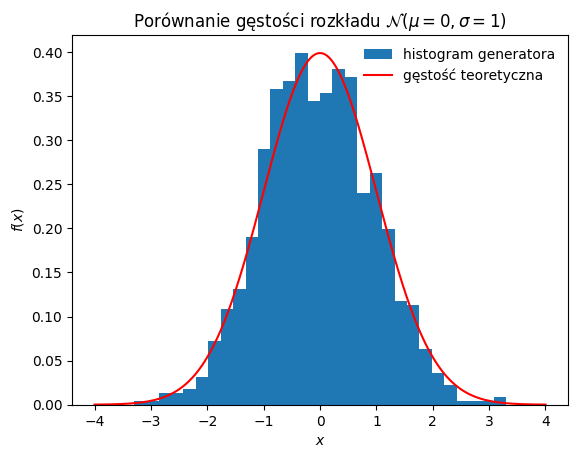

In [1041]:
visualize_pdf(X, f_th, x, name)

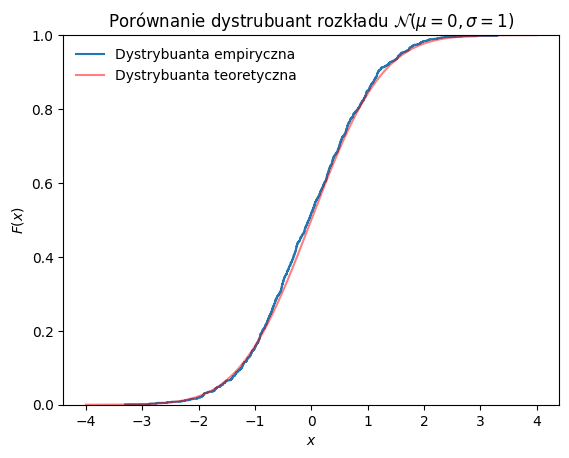

In [1042]:
visualize_cdf(X, F_th, x, name)

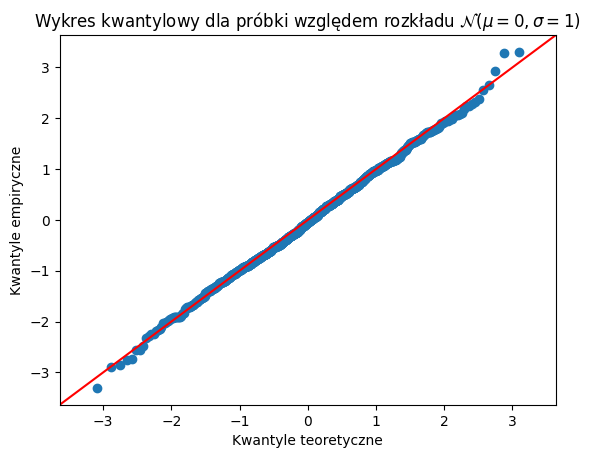

In [1043]:
quantiles(X, stats.norm(loc = mi, scale = sigma), name)

In [1044]:
print(f"Empiryczna wartość oczekiwana rozkładu: {np.mean(X)}")
print(f"Teoretyczna wartość oczekiwana standardowego rozkładu normalnego: {mi}")

Empiryczna wartość oczekiwana rozkładu: -0.03147420819475681
Teoretyczna wartość oczekiwana standardowego rozkładu normalnego: 0


In [1045]:
print(f"Empiryczna wariancja zmiennej losowej rozkładu: {np.var(X)}")
print(f"Teoretyczna wariancja standardowego rozkładu normalnego: {sigma**2}")

Empiryczna wariancja zmiennej losowej rozkładu: 0.9608033300801642
Teoretyczna wariancja standardowego rozkładu normalnego: 1


In [1046]:
print(f'Empiryczna skośność zmiennej losowej rozkładu: {skewness(X)}')
print(f'Teoretyczna skośność standardowego rozkładu normalnego: {0}')

Empiryczna skośność zmiennej losowej rozkładu: 0.04162488767924338
Teoretyczna skośność standardowego rozkładu normalnego: 0


In [1047]:
print(f'Empiryczna kurtoza zmiennej losowej rozkładu: {kurtosis(X)}')
print(f'Teoretyczna kurtoza standardowego rozkładu normalnego: {0}')

Empiryczna kurtoza zmiennej losowej rozkładu: 0.0022102473598089034
Teoretyczna kurtoza standardowego rozkładu normalnego: 0


**Wnioski:**

Możemy zauważyć, że wygenerowana przez nas realizacją zmiennej losowej są zbliżone do zmiennej losowej ze standardowego rozkładu normalnego. Gęstość teoretyczna pokrywa się z histogramem wysymulowanych wartości, podobnie jest w przypadku wykresów dystrybuant oraz kwantyli: teoretycznych i empirycznych. 
Widzimy również, że teoretyczne i empiryczne: wartości oczekiwane ($EX$), wariancje ($Var(X)$), skośności oraz kurtozy są do siebie bardzo zbliżone.

Widzimy, że metoda ta poprawnie generuje zmienną losową X z rozkładu $\mathcal{N}(0,1)$. Możemy zauważyć, że wybranie pomocniczej zmiennej losowej z rozkładu $\mathcal{Exp}(1)$ było słuszne.

- ### **Porównanie czasów działania powyższych metod generacji rozkładu normalnego:**

In [1048]:
@jit
def times():
    times_box_muller= []
    times_polar = []
    times_acceptance = []
    MC = 100
    steps = np.arange(10, 1000, 50)

    for i in steps: #aby porównywac metody trzeba by bylo uzywac list w metodzie boxa mullera
        t1 = 0
        t2 = 0
        t3 = 0
        for _ in range(MC):
        

            start_1= perf_counter()
            box_muller_method(i, mi, sigma)
            end_1 = perf_counter()
            t1 += end_1 - start_1

            start_2 = perf_counter()
            polar_method(i, mi, sigma)
            end_2 = perf_counter()
            t2 += end_2 - start_2

            start_3 = perf_counter()
            normal_acceptance_rejection_method(i, mi, sigma)
            end_3 = perf_counter()
            t3 += end_3 - start_3


        times_box_muller.append(t1/MC)
        times_polar.append(t2/MC)
        times_acceptance.append(t3/MC)

    plt.plot(steps, times_box_muller, label = "metoda boxa-mullera", c = 'grey')
    plt.plot(steps, times_polar, label = "metoda biegunowa", c = 'red')
    plt.plot(steps, times_acceptance, label = "metoda akceptacji i odrzucenia", c = 'blue')

    plt.title("Zależność czasu od wartośći $N$")
    plt.xlabel("Długość próbki $N$")
    plt.ylabel("Czas w sekundach")
    plt.legend(frameon=False)

C:\Users\Ola\AppData\Local\Temp\ipykernel_5476\2533843032.py:2: NumbaDeprecationWarning: The 'nopython' keyword argument was not supplied to the 'numba.jit' decorator. The implicit default value for this argument is currently False, but it will be changed to True in Numba 0.59.0. See https://numba.readthedocs.io/en/stable/reference/deprecation.html#deprecation-of-object-mode-fall-back-behaviour-when-using-jit for details.
  def times():


C:\Users\Ola\AppData\Local\Temp\ipykernel_5476\2533843032.py:1: NumbaWarning: 
Compilation is falling back to object mode WITH looplifting enabled because Function "times" failed type inference due to: Untyped global name 'perf_counter': Cannot determine Numba type of <class 'builtin_function_or_method'>

File "..\..\..\..\..\..\AppData\Local\Temp\ipykernel_5476\2533843032.py", line 16:
<source missing, REPL/exec in use?>

  @jit
C:\Users\Ola\AppData\Local\Temp\ipykernel_5476\2533843032.py:1: NumbaWarning: 
Compilation is falling back to object mode WITHOUT looplifting enabled because Function "times" failed type inference due to: Cannot determine Numba type of <class 'numba.core.dispatcher.LiftedLoop'>

File "..\..\..\..\..\..\AppData\Local\Temp\ipykernel_5476\2533843032.py", line 9:
<source missing, REPL/exec in use?>

  @jit
c:\Users\Ola\AppData\Local\Programs\Python\Python310\lib\site-packages\numba\core\object_mode_passes.py:151: NumbaWarning: Function "times" was compiled in obje

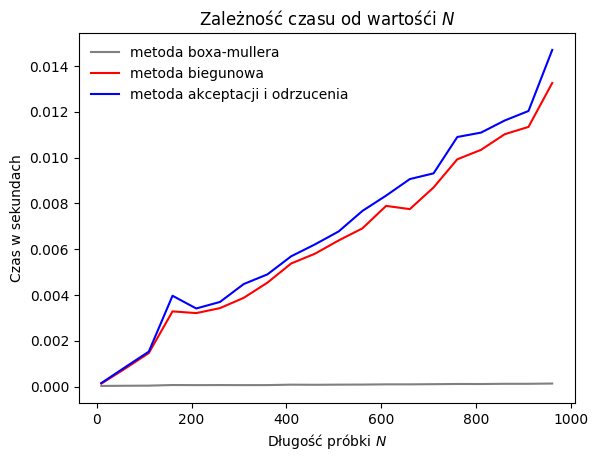

In [1049]:
times()

**Wnioski:**
Na podstawie powyższego wykresu możemy zauważyć, że najbardziej optymalna jest metoda Boxa-Mullera. 
Bardzo zbliżone czasowo do siebie są: metoda biegunowa oraz metoda akceptacji-odrzucenia, jednak z nieznaczną przewagą dla tej pierwszej. 

Dodatkowo możemy zauważyć, że czym większa jest długość próbki, tym czas dla metod: biegunowej i akceptacji-odrzucenia wydłuża się, z kolei dla metody Boxa-Mullera zmiany są znikome, prawie niewidoczne.


- ## **Algorytm Ziggurata**

Chcemy generować zmienną losową z rozkładu Pareto: $ X \sim \mathcal{Pareto}(\alpha, x_{m}), x_{m}>0, \alpha>0$, z wykorzystaniem algorytmu Ziggurata.

Dystrybuanta tego rozkładu ma postać:  $ F_X (x) = \begin{cases} 1 - (\frac{x_m}{x})^\alpha \ \ \ \ x \geqslant x_m \\ 0 \ \ \ \ \ \ \ \ \ \ \ \ \ \ \ \ \ \ \ x < x_m \end{cases} $.

Natomiast gęstość:
$ f_X (x) = \begin{cases} \frac{ \left( \alpha \ast x_m \right) ^\alpha}{x^{\alpha+1}} \ \ \ \ x \geqslant x_m \\ 0 \ \ \ \ \ \ \ \ \ \ \ \ \ \ x < x_m \end{cases} $.

Dla rozkładu $\mathcal{Pareto}(\alpha, x_{m})$ teoretyczne wartości charakterystyk wynoszą:
- wartość oczekiwana: $ EX = \frac{\alpha \ast x_m}{\alpha - 1}, $
- wariancja: $ Var(X) = \frac{\alpha}{\alpha - 2} \ast (\frac{x_m}{\alpha - 1})^2. $

Do generacji tej zmiennej losowej wykorzystamy metodę odwrotnej dystrybuanty. Dystrybuanta odwrotna została już wyżej policzona i ma postać:
$$ {F_X} ^ {-1}(y) = \frac {x_m}{(1-y)^\frac{1}{\alpha}} \stackrel{d}{=} \frac {x_m}{y^\frac{1}{\alpha}} $$

W naszym przypadku: $ \alpha = 3, x_m = 1$.

#### **Algorytm**:
1. Generuj 32-bitową liczbę całkowitą $j .\\$ Stwórz liczbę całkowitą $i$ z 8 ostatnich bitów liczby $j$.
2. Wstaw $x = j \ast w_i . \\$ Jeśli $j < k_i $ zwróć $x$.
3. Jeśli $i=0$ generuj realizację $x$ z ogona rozkładu.
4. Generuj $U \sim U(0,1) .\\$ Jeśli $(f(x_{i-1}) - f(x_i)) \ast U < f(x) - f(x_i)$ zwróć $x$.
5. Wróć do 1.


In [1065]:
def pareto(x, alpha, x_m):
    result = (alpha*x_m**alpha)/(x + x_m)**(alpha + 1) 
    return result


def pareto_cdf(x, alpha, x_m):
    result = 1 - (x_m/(x + x_m))**alpha
    return result


def inv_pareto(x, alpha, x_m):
    result = ((alpha*(x_m**alpha))/x)**(1/(alpha + 1)) - x_m
    return result

In [1066]:
x_m = 1
alpha = 3
epsilon = 3e8
N = 1000
name = "$\mathcal{Pareto}(\\alpha = 3, x_{m} = 1)$"

In [1068]:
def z(r, alpha, xm):
    x_255 = r
    x_i = x_255

    v = r * pareto(r, alpha, xm) + (xm/(r+xm))**alpha

    for _ in range(255, 1, -1): 
        x_i = inv_pareto(v/x_i + pareto(x_i, alpha, xm), alpha, xm)

    condition = v - x_i + x_i*pareto(x_i, alpha, xm) 
    return condition

def bisection(a, b, epsilon, alpha, xm,  N):
    z_a = z(a, alpha, xm)
    z_b = z(b, alpha, xm)

    if z_a * z_b <= 0:
        z_c = -1
        while abs(a-b) > 1e-4:
            c = (a + b)/2
            z_c = z(c, alpha, xm)
            if z_a * z_c < 0:
                a = a
                b = c
            elif z_b * z_c < 0:
                    a = c
                    b = b
            elif z_c == 0:
                return c
            else: 
                return None
    return (a + b)/2

a = 8.75
b = 9


r = bisection(a, b, epsilon, alpha, x_m, N)
v = r * pareto(r, alpha, x_m) + (x_m/(r+1))**alpha

print(f'Optymalne r dla podanych parametrów:  {r}')
print(f'V dla podanych parametrów:  {v}')


Optymalne r dla podanych parametrów:  8.755401611328125
V dla podanych parametrów:  0.00397724609694617


In [1069]:
x_i = [r] # bo x_255 = r
for i in range(254, 0, -1):
    x_i.append(inv_pareto(v/x_i[-1] + pareto(x_i[-1], alpha, x_m), alpha, x_m))

x_i.append(0) # bo x_0 = 0
x_i = x_i[::-1]
x_i[1] *= (-1)

print(f'Wektor x: {x_i}')

Wektor x: [0, 0.0019507028141929617, 0.017609750166632576, 0.030024904690481913, 0.03988998242679309, 0.04838971959013172, 0.05601985205625182, 0.0630397203224069, 0.06960401307847719, 0.07581336463739308, 0.08173741961515768, 0.08742666188725656, 0.09291902923347828, 0.09824386597956725, 0.10342441252961598, 0.10847944190140302, 0.11342437438803943, 0.11827205982509348, 0.12303334080730832, 0.12771746726370514, 0.13233240757423226, 0.1368850860559936, 0.14138156700656568, 0.14582719927191912, 0.1502267311949972, 0.15458440302380017, 0.15890402194495667, 0.16318902356780707, 0.16744252272878946, 0.1716673557954349, 0.17586611614341163, 0.18004118410485193, 0.1841947524047085, 0.1883288478884655, 0.1924453501811203, 0.1965460077910952, 0.20063245207433722, 0.2047062093965708, 0.20876871177049972, 0.2128213061959865, 0.21686526289212837, 0.2209017825785604, 0.22493200293766824, 0.22895700436844835, 0.2329778151255535, 0.23699541592287332, 0.24101074406923684, 0.2450246971940222, 0.249038

In [1070]:
k_0 = np.floor((2**32)*r*(pareto(r, alpha, x_m)/v))
w_0 = (0.5**32)*v/pareto(r, alpha, x_m)

k = [k_0]
w = [w_0]
for i in range(1, 256):
    k.append(np.floor((2**32)**(x_i[i - 1]/x_i[i])))
    w.append((0.5**32)*x_i[i])

print(f'Wektor k:  {k}')
print(f'Wektor w:  {w}')

Wektor k:  [3131800657.0, 1.0, 11.0, 446454.0, 17809841.0, 87279842.0, 209368535.0, 363303313.0, 530254005.0, 698216866.0, 860587685.0, 1014145480.0, 1157613363.0, 1290777995.0, 1413979948.0, 1527826126.0, 1633030345.0, 1730326880.0, 1820425342.0, 1903988824.0, 1981625034.0, 2053884532.0, 2121262721.0, 2184203649.0, 2243104568.0, 2298320638.0, 2350169460.0, 2398935279.0, 2444872804.0, 2488210618.0, 2529154204.0, 2567888617.0, 2604580821.0, 2639381752.0, 2672428113.0, 2703843956.0, 2733742064.0, 2762225164.0, 2789387000.0, 2815313261.0, 2840082417.0, 2863766445.0, 2886431475.0, 2908138360.0, 2928943187.0, 2948897723.0, 2968049821.0, 2986443775.0, 3004120643.0, 3021118530.0, 3037472848.0, 3053216547.0, 3068380319.0, 3082992791.0, 3097080690.0, 3110668998.0, 3123781086.0, 3136438848.0, 3148662807.0, 3160472220.0, 3171885179.0, 3182918687.0, 3193588746.0, 3203910420.0, 3213897911.0, 3223564608.0, 3232923153.0, 3241985483.0, 3250762883.0, 3259266025.0, 3267505012.0, 3275489407.0, 3283228277

In [1071]:
def inverse_pareto(alpha, x_m, size, r):
    U_1 = np.random.uniform(1 - (x_m / (r + x_m)) ** alpha, 1, size) 
    result = x_m/(1-U_1)**(1/alpha) - x_m
    return result

In [1072]:
def ziggurat_pareto(x_i, k, w, alpha, xm, N):
    result =[]
    for _ in range(N):
        j = getrandbits(32)
        i = int(bin(j)[-8:], base=2)
        
        x = j*w[i]
        if j < k[i]:
            result.append(x)
            continue
        elif i == 0:
            result.append(inverse_pareto(alpha, x_m, 1, r)[0])
            continue
                
        U = np.random.uniform(0, 1)
        if (pareto(x_i[i - 1], alpha, xm) - pareto(x_i[i], alpha, xm))*(U) < (pareto(x, alpha, xm) - pareto(x_i[i], alpha, xm)):
            result.append(x)
            
    result = np.array(result)
    return result    

In [1073]:
X_1 = ziggurat_pareto(x_i, k, w, alpha, x_m, 1000)
X = ziggurat_pareto(x_i, k, w, alpha, x_m, 100000)
x = np.linspace(0, r, 256)

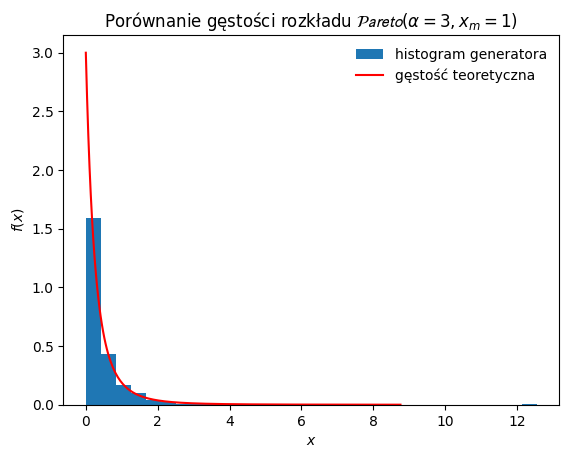

In [1074]:
visualize_pdf(X_1, pareto(x, alpha, x_m), x, name)

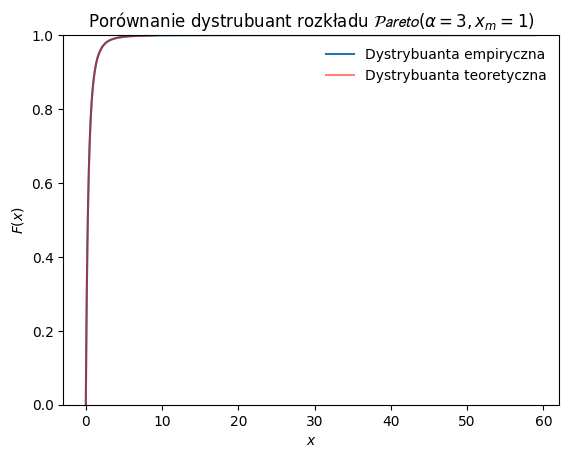

In [1075]:
visualize_cdf(X, pareto_cdf(x, alpha, x_m), x, name)

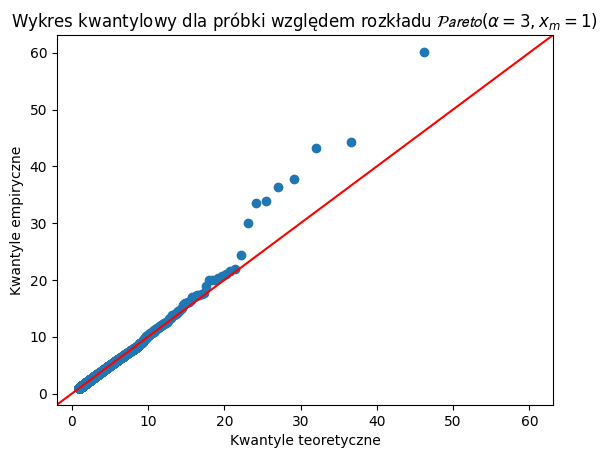

In [1076]:
quantiles(X + 1, stats.pareto(b = alpha), name)

In [1077]:
print(f"Empiryczna wartość oczekiwana rozkładu   {np.mean(X + x_m)}")
print(f"Teoretyczna wartość oczekiwana rozkładu: {alpha*x_m/(alpha - 1)}")

Empiryczna wartość oczekiwana rozkładu   1.499392113473364
Teoretyczna wartość oczekiwana rozkładu: 1.5


In [1078]:
print(f'Empiryczna wariancja rozkładu: {np.var(X + x_m)}')
print(f'Teoretyczna wariancja rozkładu: {(alpha/(alpha - 2))*(x_m/(alpha - 1))**2}')

Empiryczna wariancja rozkładu: 0.7585641121232891
Teoretyczna wariancja rozkładu: 0.75


In [1079]:
print(f'Skośność rozkładu obliczona ze wzoru: {skewness(X)}')
print(f'Skośność rozkładu obliczona przy pomocy wbudowanej funkcji: {stats.skew(X)}')

Skośność rozkładu obliczona ze wzoru: 13.362602087181948
Skośność rozkładu obliczona przy pomocy wbudowanej funkcji: 13.362602087182065


In [1080]:
print(f'Kurtoza rozkładu obliczona ze wzoru: {kurtosis(X)}')
print(f'Kurtoza rozkładu obliczona przy pomocy wbudowanej funkcji: {stats.kurtosis(X)}')

Kurtoza rozkładu obliczona ze wzoru: 490.60476808938466
Kurtoza rozkładu obliczona przy pomocy wbudowanej funkcji: 490.6047680893968


**Wnioski:**

Możemy zauważyć, że algorytm Ziggurata jest poprawną metodą generacji zmiennej losowej z rozkładu Pareto.

Gęstość teoretyczna pokrywa się z histogramem wysymulowanych wartości, podobnie jest w przypadku wykresu dystrybuant oraz kwantyli: teoretycznych i empirycznych. 
Widzimy również, że teoretyczne i empiryczne: wartości oczekiwane ($EX$), wariancje ($Var(X)$) są do siebie bardzo zbliżone.

Wartości te są także zbliżone do tych wysymulowanych za pomocą metody odwrotnej dystrybuanty.

## 3. Zakończenie.

Na podstawie porównań wszystkich powyższych wykresów gęstości teoretycznych (teoretycznych rozkładów prawdopodobieństwa) z histogramami (rozkładami prawdopodobieństwa), dystrybuant teoretycznych i empirycznych, wykresów kwantylowych (dla rozkładów ciągłych), wartości oczekiwanych oraz wariancji możemy stwierdzić, że zaimplementowane przez nas generatory są prawidłowe.

Analizując współczynniki skośności oraz kurtozy (porównane z teoretycznymi - rozkład normalny lub tymi obliczonymi przy pomocy wbudowanych funkcji - pozostałe rozkłady) mogliśmy zobaczyć czy rozkład jest lewo- czy prawostronnie skośny oraz lekko- czy ciężkoogonowy.

Widzimy także, że podczas generacji różnymi metodami zmiennych losowych z tego samego rozkładu otrzymujemy podobne wyniki.

## 4. Źródła: 
<br> [1] Sheldon M. Ross "Simulation".
<br> [2] https://linuxhint.com/use-latex-jupyter-notebook/
<br> [3] https://pl.wikibooks.org/wiki/LaTeX/Matematyka
<br> [4] Marsaglia, George, Wai Wan Tsang ”The ziggurat method for generating random variables.” Journal of statistical software 5 (2000): 1-7.
<br> [5] W.Feller "Wstęp do rachunku prawdopodobieństwa", tom 1 i 2.
<br> [6] https://patrickwalls.github.io/mathematicalpython/root-finding/bisection/
<br> [7] https://linuxhint.com/use-latex-jupyter-notebook/
<br> [8] https://pl.wikibooks.org/wiki/LaTeX/Matematyka
<br> [9] Wiedza oraz notatki z wykładów z przedmiotu "Symulacje komputerowe" prowadzonych przez prof. dr hab. inż. Marcina Magdziarza, wykładów z przedmiotu "Rachunek Prawdopodobieństwa" prowadzonych przez dr hab. inż. Agnieszkę Jurlewicz i laboratoriów z przedmiotu "Symulacje komputerowe" prowadzonych przez dr inż. Mateusza Świtałę.

